# AutoInland Vehicle Insurance Claim Challenge 
_This is a notebook by Samson Tontoye._

# **Table of Contents**
1. [Problem Definition](#problem)\
2. [Read Data](#read)\
3. [EDA](#eda)\
    3.1 [Custom Color Palette](#color)\
    3.2 [Numeric Variables](#numeric)\
    3.3 [Categorical Variables](#categorical)
4. [Feature Engineering](#features)
5. [Modelling](#models)\
    5.1 [Logistic Regression](#logreg)\
    5.2 [Random Forest](#forest)\
    5.3 [KNeighborsClassifier](#neighbors)\
    5.4 [LightGBM](#lgbm)\
    5.5 [CatBoost](#catboost)\
    5.6 [XGBoost](#xgb)\   
6. [Conclusion](#conclusion)

## Introduction
This notebook looks into using various python-based machine learning and data science libraries in an attempt to develop a predictive machine learning model that determines if a customer will submit a vehicle insurance claim within next three months from their first transaction.

## What we'll end up with
Since we already have a dataset, we'll approach the problem with the following machine learning modelling framework.

To work through these topics, we'll use pandas, Matplotlib and NumPy for data anaylsis, as well as, Scikit-Learn for machine learning and modelling tasks.

We'll work through each step and by the end of the notebook, we'll have a handful of models, all which can predict whether or not a customer will claim insurance within the first three months using precision, recall and F1 score as the evaluation metric.

## **1. Problem Definition**

<a id="problem"></a>

This notebook is an insurance claim classification machine learning project with an imbalanced class.In this case, the problem we will be exploring is binary classification (a sample can only be one of two things).

This is because we are going to be using a number of different features (pieces of information) to predict if a customer will submit a vehicle insurance claim within next three months from their first transaction.

## 2. Data

The dataset came from Zindi in a formatted way [Zindi](https://zindi.africa/competitions/autoinland-vehicle-insurance-claim-challenge/data)

The data describes ~12,000 policies sold by AutoInland for car insurance. Information on the car type, make, customer age and start of policy are in the data.

## 3. Evaluation

The evaluation metric is something to define at the start of a project.

Since machine learning is very experimental:

           Since we are working with a highly imbalanced dataset, we will use the precision, recall and F1 score as an appropriate evaluation metric. If we can get a score of say 0.9 or over across this three evaluation metric at predicting whether or not a customer will submit a vehicle insurance claim within next three months from their first transaction during the proof of concept, we'll pursue this project.
           
## 4. Features

Features are different parts of the data. We're going to visualize the relationships between the different features of the data and how it can lead to a customer that will submit an insurance claim.

One of the most common ways to understand the features is to look at the **data dictionary**. For this project, the data dictionary is in the **Variable Definitions** csv file.

In [3671]:
# Data Manipulation
import numpy as np
import pandas as pd
import scipy

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import plotly.express as px
import plotly.figure_factory as ff

# Feature Selection and Encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Machine Learning
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

# For the imbalanced dataset
from imblearn.over_sampling import SMOTE

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_roc_curve

# Manage warnings
import warnings
warnings.filterwarnings('ignore')

#For Datetime
import datetime as dt

from tqdm.notebook import tqdm_notebook
from collections import Counter

# Plot the figure inline
%matplotlib inline 

## **2. Read Data**

<a id="read"></a>

In [3672]:
# Load the data into a pandas dataframe
train = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/Train.csv',
                    low_memory=False,
                    parse_dates=['Policy Start Date', 'Policy End Date', 'First Transaction Date'])
test = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/Test.csv',
                   low_memory=False,
                    parse_dates=['Policy Start Date', 'Policy End Date', 'First Transaction Date'])
ss = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/SampleSubmission.csv')
var_def = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/VariableDefinitions.csv')
state_names = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/NigerianStateNames.csv')

## **3. Exploratory Data Analysis**

<a id="eda"></a>

**Cleaning**: To clean our data, we'll need to work with:

* **Missing values**: Either omit elements from a dataset that contain missing values or impute them (fill them in).
* **Special values**: Numeric variables are endowed with several formalized special values including ±Inf, NA and NaN. Calculations involving special values often result in special values, and need to be handled/cleaned.
* **Outliers**: They should be detected, but not necessarily removed. Their inclusion in the analysis is a statistical decision.
* **Obvious inconsistencies**: A person's age cannot be negative, an under-aged person cannot possess a drivers license. Find the inconsistencies and plan for them.

When exploring our dataset and its features, we have many options available to us. We can explore each feature individually, or compare pairs of features, finding the correlation between. Let's start with some simple Univariate (one feature) analysis.

Features can be of multiple types:

* Nominal: is for mutual exclusive, but not ordered, categories.
* Ordinal: is one where the order matters but not the difference between values.
* Interval: is a measurement where the difference between two values is meaningful.
* Ratio: has all the properties of an interval variable, and also has a clear definition of 0.0.

There are multiple ways of manipulating each feature type, but for simplicity, we'll define only two feature types:

* Numerical: any feature that contains numeric values.
* Categorical: any feature that contains categories, or text.

Since EDA has no real set methodology, the following is a short check list to to walk through:

1. From the dataframe features, what features are the highest indicator that the customer will claim insurance in the first 3 months?
2. What’s missing from the data and how do you deal with it?
3. Does gender play a role in a customer claiming insurance in the first 3 months?
4. Does policy start date play a role in a customer claiming insurance in the first 3 months?
5. Does policy end date/First transaction date play a role in a customer claiming insurance in the first 3 months?

In [3673]:
# Top 5 rows of the train dataframe
train.head()

ID Policy Start Date Policy End Date  Gender  Age  \
0  ID_0040R73        2010-05-14      2011-05-13    Male   30   
1  ID_0046BNK        2010-11-29      2011-11-28  Female   79   
2  ID_005QMC3        2010-03-21      2011-03-20    Male   43   
3  ID_0079OHW        2010-08-21      2011-08-20    Male    2   
4  ID_00BRP63        2010-08-29      2010-12-31  Entity   20   

  First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0             2010-05-14       1       Saloon              Black   
1             2010-11-29       1         JEEP               Grey   
2             2010-03-21       1       Saloon                Red   
3             2010-08-21       1          NaN                NaN   
4             2010-08-29       3          NaN                NaN   

  Subject_Car_Make LGA_Name  State  ProductName  target  
0           TOYOTA      NaN    NaN  Car Classic       0  
1           TOYOTA      NaN    NaN  Car Classic       1  
2           TOYOTA      NaN    NaN  Car Classic       0  
3              NaN      NaN    NaN      CarSafe       0  
4              NaN    Lagos  Lagos        Muuve       1

In [3674]:
# Top 5 rows of the test dataframe
test.head()

ID Policy Start Date Policy End Date  Gender  Age  \
0  ID_01QM0NU        2010-10-23      2011-10-22  Female   46   
1  ID_024NJLZ        2010-10-14      2011-10-13    Male   32   
2  ID_02NOVWQ        2010-08-29      2011-08-28  Female   45   
3  ID_02VSP68        2010-06-13      2011-06-12  Female   58   
4  ID_02YB37K        2010-07-01      2011-06-30     NaN  120   

  First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0             2010-10-23       1          NaN                NaN   
1             2010-10-14       1          NaN                NaN   
2             2010-08-29       2       Saloon              Black   
3             2010-06-13       1       Saloon                NaN   
4             2010-07-01       1       Saloon                Red   

  Subject_Car_Make         LGA_Name            State  ProductName  
0             Ford  Abuja Municipal  Abuja-Municipal  Car Classic  
1              NaN           Kosofe            Benue  Car Classic  
2            Honda          Wuse 11            Abuja  Car Classic  
3           TOYOTA              NaN              NaN      CarSafe  
4          Hyundai  Victoria Island            Lagos  Car Classic

In [3675]:
# Check the variable definition
var_def

ID  \
0           Policy Start Date   
1             Policy End Date   
2                      Gender   
3                         Age   
4                 ProductName   
5      First Transaction Date   
6                      No_Pol   
7                Car_Category   
8          Subject_Car_Colour   
9            Subject_Car_Make   
10                   LGA_Name   
11                      State   
12  No_of_claims_3_mon_period   

                           Unique ID for the customer  
0                                 Date policy started  
1                                   Date policy ended  
2                              Gender of the customer  
3                                 Age of the customer  
4                            Name of Insurance policy  
5                         First date payment was made  
6                 Number of policies the customer has  
7                                         Type of car  
8                                          Car colour  
9                                            Car make  
10                    City where policy was purchased  
11                   State where policy was purchased  
12  Wether the customer claimed within a 3 month p...

In [3676]:
# Check the state names
state_names

LGA                         State
0           Abadam                   Borno State
1            Abaji     Federal Capital Territory
2             Abak               Akwa Ibom State
3        Abakaliki                  Ebonyi State
4        Aba-North                    Abia State
..             ...                           ...
870          Warri              Warri-South-West
871  Warri-Central                   Warri-South
872        Wuse-11  Abuja-Municipal-Area-Council
873           Yaba                Lagos-Mainland
874            NaN                       Unknown

[875 rows x 2 columns]

In [3677]:
# Let's see how many positive (1) and negative (0) samples we have in our dataframe
print('Length of the train dataset:', len(train))
print('Length of the test dataset:', len(test))
print('Total no of customers that will not claim insurance in the first 3 months:', len(train[train['target']==0]))
print('Total no of customers that will claim insurance in the first 3 months:', len(train[train['target']==1]))

Length of the train dataset: 12079
Length of the test dataset: 1202
Total no of customers that will not claim insurance in the first 3 months: 10624
Total no of customers that will claim insurance in the first 3 months: 1455


Since these two values(Customers that will claim insurance within the first 3 months and customers that will not claim insurance in the first 3 months) are not close, our target column can be considered **imbalanced**. An **imbalanced** target column, meaning some classes have far more samples, can be harder to model than a balanced set. From our target column, if the customer will claim insurance in the first 3 months, it is denoted with 1, if the customer will not claim insurance in the first 3 months, it is denoted as 0.

In [3678]:
# To see the value in percentages
train['target'].value_counts(normalize=True)

0    0.879543
1    0.120457
Name: target, dtype: float64

The proportion of customer that will not claim insurance in the first 3 months to those that will claim insurance in the first 3 months is 7.3:1. 1 in 7 customers will claim insurance in the first 3 months.

In [3679]:
# Check the shape of the train and test dataset
print(f'The shape of the train dataset is: {train.shape}\nThe shape of the test dataset is: {test.shape}')

The shape of the train dataset is: (12079, 14)
The shape of the test dataset is: (1202, 13)


In [3680]:
# Check the information for the training dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      12079 non-null  object        
 1   Policy Start Date       12079 non-null  datetime64[ns]
 2   Policy End Date         12079 non-null  datetime64[ns]
 3   Gender                  11720 non-null  object        
 4   Age                     12079 non-null  int64         
 5   First Transaction Date  12079 non-null  datetime64[ns]
 6   No_Pol                  12079 non-null  int64         
 7   Car_Category            8341 non-null   object        
 8   Subject_Car_Colour      5117 non-null   object        
 9   Subject_Car_Make        9603 non-null   object        
 10  LGA_Name                5603 non-null   object        
 11  State                   5591 non-null   object        
 12  ProductName             12079 non-null  object

In [3681]:
# Check for missing values in the training dataset
train.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     359
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              3738
Subject_Car_Colour        6962
Subject_Car_Make          2476
LGA_Name                  6476
State                     6488
ProductName                  0
target                       0
dtype: int64

In [3682]:
# Check the information for the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      1202 non-null   object        
 1   Policy Start Date       1202 non-null   datetime64[ns]
 2   Policy End Date         1202 non-null   datetime64[ns]
 3   Gender                  1161 non-null   object        
 4   Age                     1202 non-null   int64         
 5   First Transaction Date  1202 non-null   datetime64[ns]
 6   No_Pol                  1202 non-null   int64         
 7   Car_Category            830 non-null    object        
 8   Subject_Car_Colour      505 non-null    object        
 9   Subject_Car_Make        954 non-null    object        
 10  LGA_Name                546 non-null    object        
 11  State                   546 non-null    object        
 12  ProductName             1202 non-null   object  

From the pandas test dataframe above,

* Age and No_Pol are int datatype.
* Policy Start Date, Policy End Date and First Transaction Date are datetime datatype.
* The rest of the columns are object datatype.

In [3683]:
# The .describe() function will demonstrate the count, mean, std dev, min, max, etc values for the 
# Numerical features present in the  train dataset.
train.describe()

Age        No_Pol        target
count  12079.000000  12079.000000  12079.000000
mean      42.234539      1.307227      0.120457
std       97.492565      0.733085      0.325509
min    -6099.000000      1.000000      0.000000
25%       35.000000      1.000000      0.000000
50%       41.000000      1.000000      0.000000
75%       50.000000      1.000000      0.000000
max      320.000000     10.000000      1.000000

In [3684]:
# The .describe() function will demonstrate the count, mean, std dev, min, max, etc values for the 
# Numerical features present in the test dataset
test.describe()

Age       No_Pol
count  1202.000000  1202.000000
mean     43.792845     1.257903
std      19.986245     0.613510
min     -26.000000     1.000000
25%      35.000000     1.000000
50%      41.000000     1.000000
75%      50.000000     1.000000
max     120.000000     7.000000

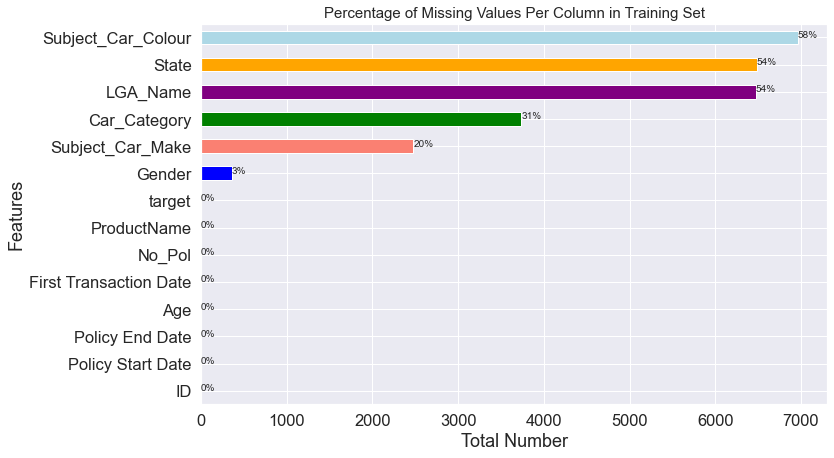

In [3685]:
# Visualizing the missing values in the training dataset
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7),
                                           color=['indigo', 'yellow', 'brown', 'pink',
                                                 'cyan', 'gray', 'olive', 'orangered',
                                                 'blue', 'salmon', 'green', 'purple',
                                                 'orange','lightblue', 'red', 'violet'])

# Add some attributes
plt.title('Percentage of Missing Values Per Column in Training Set', fontdict={'size':15})
plt.xlabel('Total Number')
plt.ylabel('Features')

for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y));

In [3686]:
# Check for missing values in the test dataset
test.isna().sum()

ID                          0
Policy Start Date           0
Policy End Date             0
Gender                     41
Age                         0
First Transaction Date      0
No_Pol                      0
Car_Category              372
Subject_Car_Colour        697
Subject_Car_Make          248
LGA_Name                  656
State                     656
ProductName                 0
dtype: int64

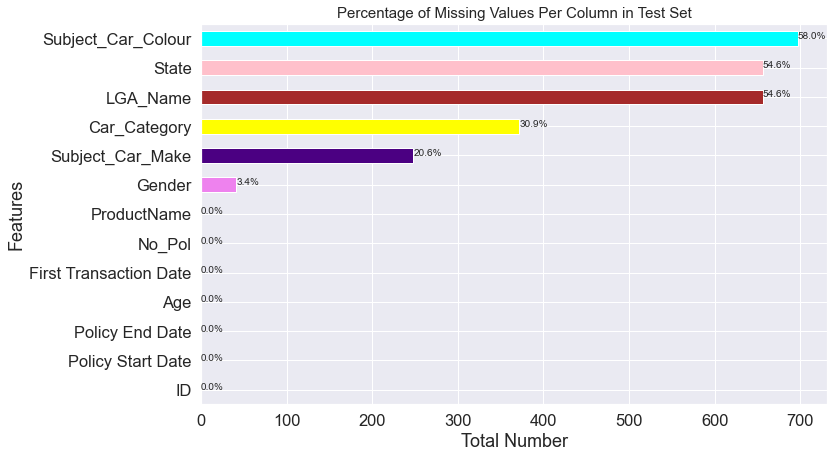

In [3687]:
# Visualizing the missing values in the test dataset
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7),
                                          color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})
plt.xlabel('Total Number')
plt.ylabel('Features')

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [3688]:
train.columns

Index(['ID', 'Policy Start Date', 'Policy End Date', 'Gender', 'Age',
       'First Transaction Date', 'No_Pol', 'Car_Category',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName', 'target'],
      dtype='object')

<p style="text-align:center;">Investigate numeric variables- Age, No_Pol</p>

<p style="text-align:center;">Histograms for each, their effect on the target.</p>

<p style="text-align:center;">Potentially graph their effects</p>

### 3.1 Create Custom Color Palette

<a id="color"></a>

Text(-0.5, -0.7, 'Color Palette For This Notebook')

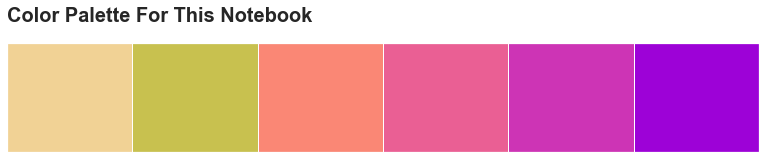

In [3689]:
# Create the different shades of colors for the color pallete
colors = ["#f1d295", "#c8c14f", "#fa8775", "#ea5f94", "#cd34b5", "#9d02d7"]
palette = sns.color_palette(palette = colors)

sns.palplot(palette, size = 2)
plt.text(-0.5, -0.7, 'Color Palette For This Notebook', size = 20, weight = 'bold')

### 3.2 Numeric Variables

<a id="numeric"></a>

<p style="text-align:center;"><b>Age Distribution of Customers.</b></p>

Text(0, 0.5, 'Count')

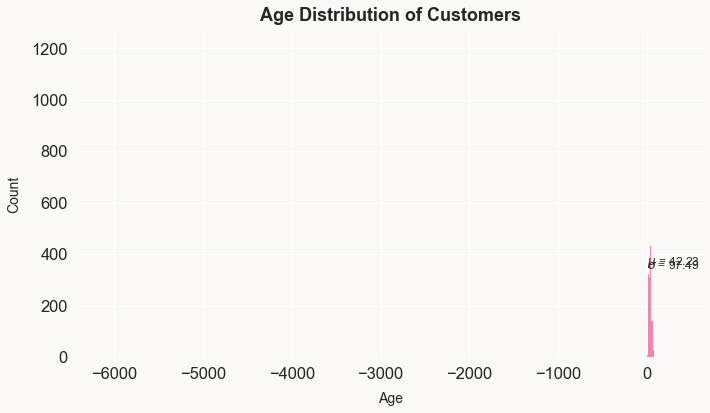

In [3690]:
# Plot the histogram for the age distribution of customers
fig, ax = plt.subplots(figsize = (10,6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

sns.histplot(
    train['Age'],
    kde = False,
    color = "#ea5f94"
)

for i in ['top', 'left', 'bottom', 'right']:
    ax.spines[i].set_visible(False)

plt.text(5, 360, r'$\mu$ = '+str(round(train['Age'].mean(), 2)), fontsize = 12)
plt.text(5, 343, r'$\sigma$ = '+str(round(train['Age'].std(), 2)), fontsize = 12)
plt.title('Age Distribution of Customers', fontsize = 18, fontweight = 'bold', pad = 10)
plt.xlabel('Age', fontsize = 14, labelpad = 10)
plt.ylabel('Count', fontsize = 14, labelpad = 10)

### Check for Outliers in Age

<AxesSubplot:ylabel='Age'>

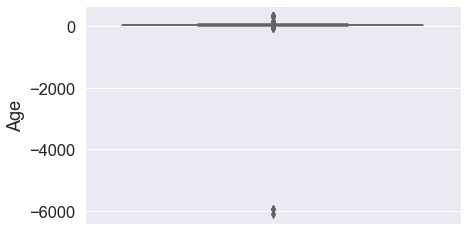

In [3691]:
# Plot a boxplot of the age of the customers showing the spread and IQR before removing outliers
sns.boxplot(y = 'Age', data = train ,palette='Accent')

In [3692]:
# Visualize the age distribution of the customers before removing outliers
Age = list(train['Age'].values)
hist_data=[Age]

group_labels=['Age']
colour=['Red']

fig = ff.create_distplot(hist_data, group_labels, show_hist=True, colors=colour)
fig.show()
print('The shape before removing the Age outliers :', train.shape)

The shape before removing the Age outliers : (12079, 14)


In [3694]:
# Visualize the age distribution of the customers after removing outliers
Age=list(train['Age'].values)
hist_data=[Age]

group_lables=['Age']
colour=['Red']

fig=ff.create_distplot(hist_data,group_lables,show_hist=True,colors=colour)
fig.show()

train.drop(train[train['Age'] < 0].index, inplace = True)
train.drop(train[train['Age'] < 18].index, inplace = True)
train.drop(train[train['Age'] > 150].index, inplace = True)
print("The shape after removing the Age outliers : ",train.shape)

The shape after removing the Age outliers :  (11511, 14)


In [3695]:
# Visualize the spread of the age distribution of the customers after removing outliers
train_Age = train.groupby('Age', as_index=False)['target'].sum()
fig = px.histogram(train_Age, 
                   x = "Age",
                   y = "target", 
                   barmode = "group", 
                   nbins = 10, 
                   opacity = 0.75, 
                   range_x = [0,85],
                   color_discrete_sequence=px.colors.qualitative.Light24)

fig.update_layout(height = 500, 
                  width = 700, 
                  title_text ='Age Distribution of Customers',
                  title_font_size= 20,
                  title_y = 0.97,
                  title_x = 0.48,
                  yaxis_title = 'Count')

fig.show()

<AxesSubplot:ylabel='Age'>

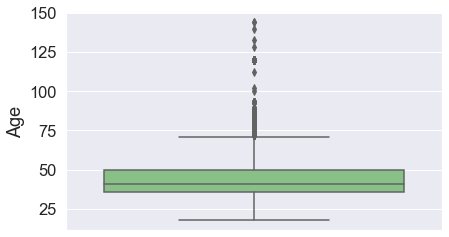

In [3696]:
# Plot a boxplot of the age of the customers showing the spread and IQR after removing outliers
sns.boxplot(y = 'Age', data = train ,palette='Accent')

**Observation**:

After removing the outliers, the range is now between 18 and 144 which is where most of the age samples are distributed. 

<p style="text-align:center;"><b>Frequency of Number of Policies.</b></p>

Text(0, 0.5, 'Count')

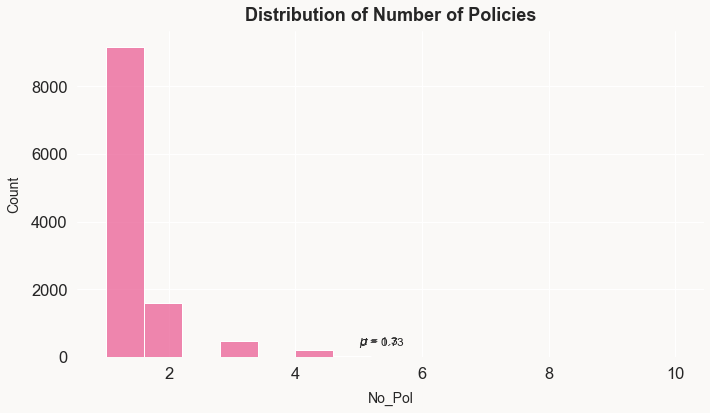

In [3697]:
fig, ax = plt.subplots(figsize = (10,6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

sns.histplot(
    train['No_Pol'],
    kde = False,
    color = "#ea5f94"
)

for i in ['top', 'left', 'bottom', 'right']:
    ax.spines[i].set_visible(False)

plt.text(5, 360, r'$\mu$ = '+str(round(train['No_Pol'].mean(), 2)), fontsize = 12)
plt.text(5, 343, r'$\sigma$ = '+str(round(train['No_Pol'].std(), 2)), fontsize = 12)
plt.title('Distribution of Number of Policies', fontsize = 18, fontweight = 'bold', pad = 10)
plt.xlabel('No_Pol', fontsize = 14, labelpad = 10)
plt.ylabel('Count', fontsize = 14, labelpad = 10)

### Check Outliers in Number of Policies

<AxesSubplot:ylabel='No_Pol'>

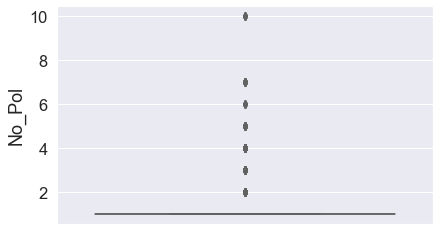

In [3698]:
# Plot a boxplot of the number of policies of the customers showing the spread and IQR with outliers
sns.boxplot(y = 'No_Pol', data = train ,palette='Accent')

In [3699]:
# Display the Number of Policies Outliers
No_Pol = list(train['No_Pol'].values)
hist_data=[No_Pol]

group_labels=['No_Pol']
colour=['Red']

fig = ff.create_distplot(hist_data, group_labels, show_hist=True, colors=colour)
fig.show()
print('Display the Number of Policies Outliers :', train.shape)

Display the Number of Policies Outliers : (11511, 14)


<AxesSubplot:ylabel='No_Pol'>

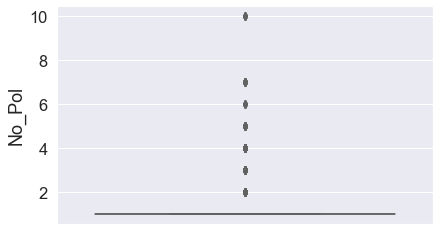

In [3700]:
# Plot a boxplot of the number of policies of the customers showing the spread and IQR after removing outliers
sns.boxplot(y = 'No_Pol', data = train ,palette='Accent')

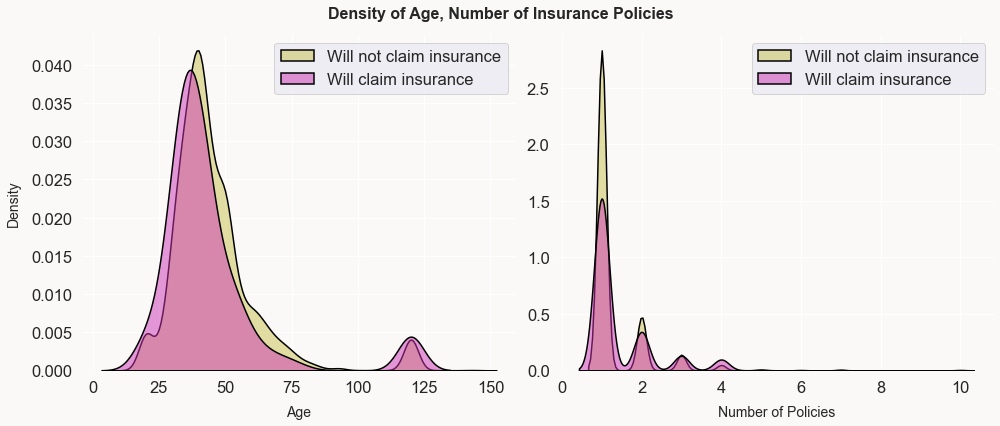

In [3701]:
# Plot the density plot of the Age and Number of Policies of Insurance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
fig.patch.set_facecolor('#faf9f7')

for i in (ax1, ax2):
    i.set_facecolor('#faf9f7')
    
sns.kdeplot(
    train['Age'][train['target'] == 0],
    ax = ax1,
    color = '#c8c14f',
    shade = True,
    alpha = 0.5,
    linewidth = 1.5,
    ec = 'black'
)

sns.kdeplot(
    train['Age'][train['target'] == 1],
    ax = ax1,
    color = '#cd34b5',
    shade = True,
    alpha = 0.5,
    linewidth = 1.5,
    ec = 'black'
)

ax1.legend(['Will not claim insurance', 'Will claim insurance'], loc = 'upper right')
ax1.set_xlabel('Age', fontsize = 14, labelpad = 10)
ax1.set_ylabel('Density', fontsize = 14, labelpad = 10)

sns.kdeplot(
    train['No_Pol'][train['target'] == 0],
    ax = ax2,
    color = '#c8c14f',
    shade = True,
    alpha = 0.5,
    linewidth = 1.5,
    ec = 'black'
)

sns.kdeplot(
    train['No_Pol'][train['target'] == 1],
    ax = ax2,
    color = '#cd34b5',
    shade = True,
    alpha = 0.5,
    linewidth = 1.5,
    ec = 'black'
)

ax2.legend(['Will not claim insurance', 'Will claim insurance'], loc='upper right')
ax2.set_xlabel('Number of Policies', fontsize = 14, labelpad = 10)
ax2.set_ylabel('')

plt.suptitle('Density of Age, Number of Insurance Policies', fontsize = 16, fontweight = 'bold')

for i in (ax1, ax2):
    for j in ['top', 'left', 'bottom', 'right']:
        i.spines[j].set_visible(False)

fig.tight_layout()


<p style="text-align:center;"><b>Scatter plots of numerical variables colored by insurance.</b></p>

In [3702]:
# Assign the target column to a variable
will_claim_insurance = train[train['target'] == 1]
will_not_claim_insurance = train[train['target'] == 0]

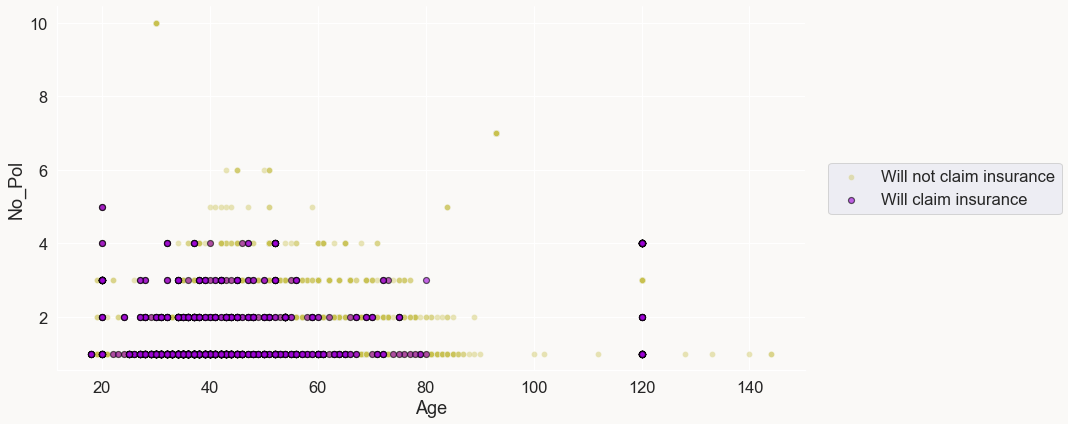

In [3705]:
# Plot a scatter plot of the number of insurance policies against age
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.patch.set_facecolor('#faf9f7')
for j in range(0, 1):
    ax.set_facecolor('#faf9f7')

## Age vs Number of Policies
sns.scatterplot(
    data = will_not_claim_insurance, x = 'Age', y = 'No_Pol', color = '#c8c14f',
    alpha = 0.4, ax = ax
)
sns.scatterplot(
    data = will_claim_insurance, x = 'Age', y = 'No_Pol', color = "#9d02d7",
    ax = ax, edgecolor = 'black', linewidth = 1.2, alpha = 0.6
)
    
sns.despine()

for i in range(0, 1):
    ax.legend(['Will not claim insurance', 'Will claim insurance'], loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)
    

fig.tight_layout()

### 3.3 Categorical Variables

<a id="categorical"></a>

<p style="text-align:center;"><b>Let's first investigate the target variable.</b></p>

In [3706]:
# Check the proportion of classes of the target column
train['target'].value_counts(normalize = True)

0    0.878464
1    0.121536
Name: target, dtype: float64

Text(0.5, 1.0, 'Percentage of Target')

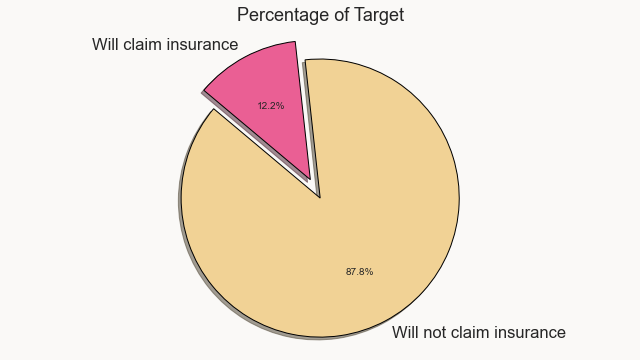

In [3707]:
# Plot a pie chart of the target column showing the proportion
fig, ax = plt.subplots(figsize = (10, 6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

labels = ['Will not claim insurance', 'Will claim insurance']
colors = ['#f1d295', '#ea5f94']
sizes = train['target'].value_counts()

plt.pie(sizes, explode = [0, 0.15], labels = labels, colors = colors,
           autopct = '%1.1f%%', shadow = True, startangle = 140,
           wedgeprops = {'ec': 'black'}, textprops = {'fontweight': 'medium'}
)

plt.axis('equal')
plt.title('Percentage of Target')

<p style="text-align:center;"><b>Gender</b></p>

In [3708]:
# Check the number of genders
train.Gender.value_counts()

Male            7322
Female          3193
Joint Gender     215
Entity           201
NOT STATED       146
NO GENDER         62
SEX               35
Name: Gender, dtype: int64

In [3709]:
# Replace gender that is not male or female with other
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
train.Gender = train.Gender.replace(mapper)

# Confirm mappings
train.Gender.value_counts()

Male      7322
Female    3193
Other      659
Name: Gender, dtype: int64

In [3710]:
# Replace the other with nan
train['Gender'] = train['Gender'].replace({'Other': np.nan})
train['Gender']

0          Male
1        Female
2          Male
4           NaN
5          Male
          ...  
12074    Female
12075    Female
12076      Male
12077       NaN
12078    Female
Name: Gender, Length: 11511, dtype: object

In [3711]:
# Drop cases where either variable is missing
data = train[['Gender', 'target']].dropna() 
pd.crosstab(data.Gender, data.target)

target     0    1
Gender           
Female  2842  351
Male    6432  890

Text(0.5, 1.0, 'Percentage of Gender')

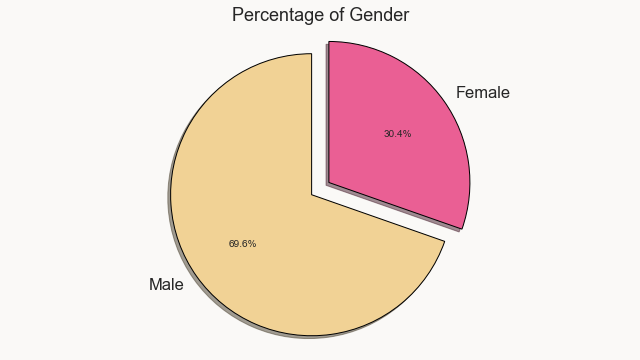

In [3712]:
# Plot a pie chart of the gender column showing the proportion of male to female
fig, ax = plt.subplots(figsize = (10, 6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

labels = ['Male', 'Female']
colors = ['#f1d295', '#ea5f94']
sizes = train['Gender'].value_counts()

plt.pie(sizes, explode = [0, 0.15], labels = labels, colors = colors,
           autopct = '%1.1f%%', shadow = True, startangle = 90,
           wedgeprops = {'ec': 'black'}, textprops = {'fontweight': 'medium'}
)

plt.axis('equal')
plt.title('Percentage of Gender')

Text(0.5, 50.0, 'target')

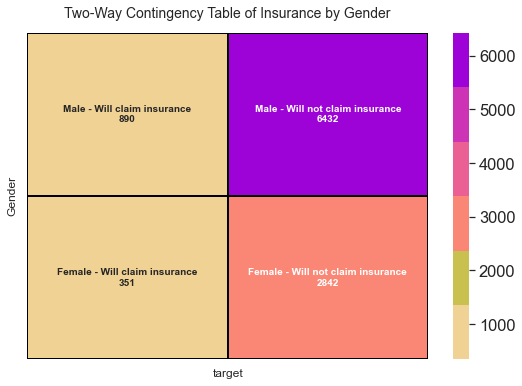

In [3713]:
# plot a two way contingency table of insurance by gender
plt.subplots(figsize=(8,6))

insurance_matrix = np.array([[890, 6432], [351, 2842]])
labels = np.array([['Male - Will claim insurance', 'Male - Will not claim insurance'], 
                   ['Female - Will claim insurance', 'Female - Will not claim insurance']])
formatted = (np.asarray(["{0}\n{1:.0f}".format(text, data) for text, data in zip(labels.flatten(), insurance_matrix.flatten())])).reshape(2,2)


sns.heatmap(
    insurance_matrix,
    annot = formatted,
    fmt = '',
    cmap = palette,
    xticklabels = False,
    yticklabels = False,
    linecolor = 'black',
    linewidth = 1,
    annot_kws = {'fontweight': 'semibold'}
)
plt.title('Two-Way Contingency Table of Insurance by Gender', pad = 15, fontsize = 14)
plt.ylabel('Gender', fontsize = 12, labelpad = 10)
plt.xlabel('target', fontsize = 12, labelpad = 10)

**Observation**:

Since there are 3193 women, 2842 women will not claim insurance and 348 of them will claim insurance, we might infer, based on this one variable if the customer is a woman, there's a 11% chance the female customer will claim insurance.

As for males, there are 7322 males, 6432 men will not claim insurance and 890 of them will claim insurance. So we might predict, if the customer is male, there is a 12.2% chance he will claim insurance.

Averaging these two values, we can assume, based on no other parameters, if there's a person, there's a 11.6% chance they will claim insurance.

<p style="text-align:center;"><b>Car Category</b></p>

In [3714]:
# Check the proportion of each car in the car category
train.Car_Category.value_counts(normalize=True)

Saloon                     0.723378
JEEP                       0.244425
Truck                      0.011150
Bus                        0.006264
Mini Bus                   0.004260
Pick Up                    0.002756
Motorcycle                 0.001629
Mini Van                   0.001503
Sedan                      0.001503
Wagon                      0.001002
Shape Of Vehicle Chasis    0.000752
Station 4 Wheel            0.000626
Van                        0.000376
Tipper Truck               0.000125
Pick Up > 3 Tons           0.000125
CAMRY CAR HIRE             0.000125
Name: Car_Category, dtype: float64

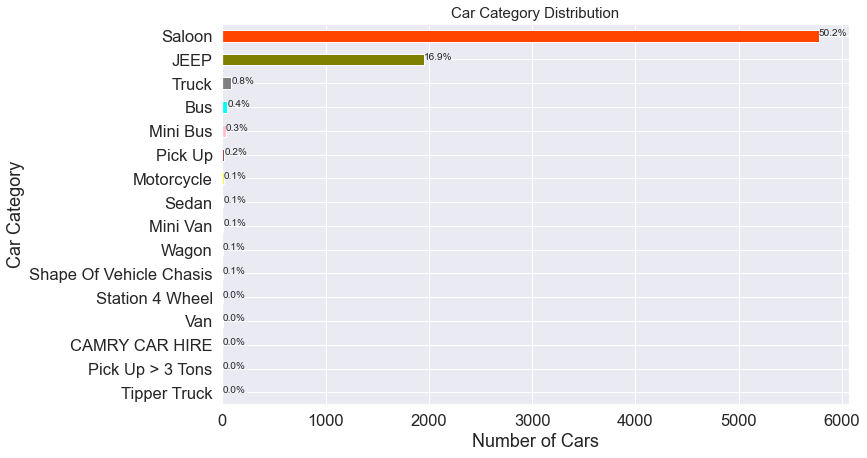

In [3715]:
# Car_category Distribution before Joining
ax = train.Car_Category.value_counts().sort_values().plot(kind='barh', 
                                                            figsize=(10, 7), 
                                                            color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('Car Category Distribution', fontdict={'size': 15})
plt.xlabel('Number of Cars')
plt.ylabel('Car Category')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/train.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

In [3716]:
# Replace car category that is not saloon or jeep with others
mapper = {'Truck':'Others', 'Mini Bus':'Others', 'Bus':'Others', 'Pick Up': 'Others', 'Sedan':"Others", 'Motorcycle': 'Others', 
          'Mini Van':'Others', 'Wagon': 'Others', 'Shape Of Vehicle Chasis': 'Others', 'Station 4 Wheel': 'Others', 'Van': 'Others',
          'Pick Up > 3 Tons': 'Others', 'CAMRY CAR HIRE': 'Others', 'Tipper Truck': 'Others'}
train.Car_Category = train.Car_Category.replace(mapper)

# Confirm mappings
train.Car_Category.value_counts()

Saloon    5774
JEEP      1951
Others     257
Name: Car_Category, dtype: int64

Text(0.5, 1.0, 'Percentage of Car Category')

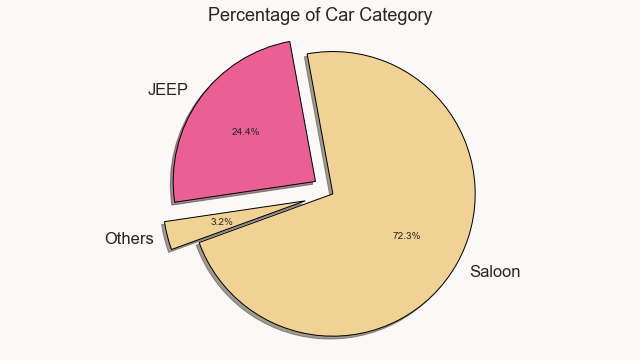

In [3717]:
# Plot a pie chart of the car category column showing the proportion after joining
fig, ax = plt.subplots(figsize = (10, 6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

labels = ['Saloon', 'JEEP', 'Others']
colors = ['#f1d295', '#ea5f94']
sizes = train['Car_Category'].value_counts()

plt.pie(sizes, explode = [0, 0.15, 0.2], labels = labels, colors = colors,
           autopct = '%1.1f%%', shadow = True, startangle = 200,
           wedgeprops = {'ec': 'black'}, textprops = {'fontweight': 'medium'}
)

plt.axis('equal')
plt.title('Percentage of Car Category')

**Observation:**

72.3% of the vehicles insured by AutoInland insurance are saloon cars, 24.4% of vehicles insured are jeeps and 3.2% of vehicles insured have been grouped as others.

In [3718]:
# Compare the target column to car_category
pd.crosstab(train.Car_Category, train.target)

target           0    1
Car_Category           
JEEP          1714  237
Others         202   55
Saloon        4978  796

#### Frequency of Car Category

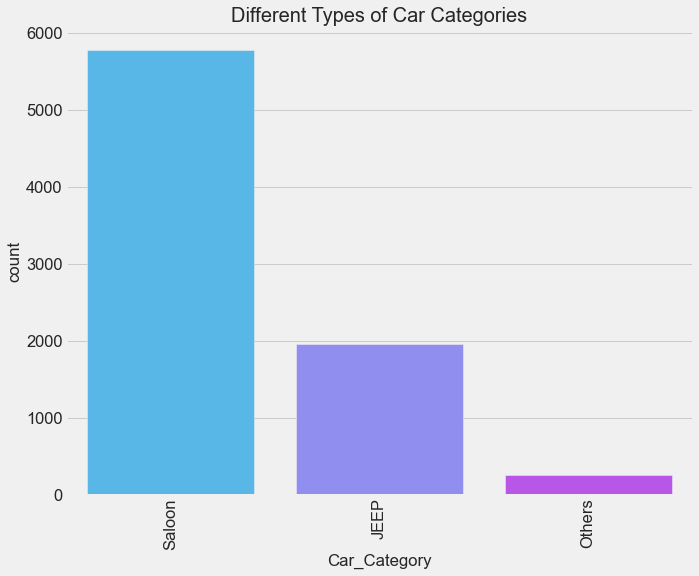

In [3719]:
# let's check the car categories

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 8)

sns.countplot(train['Car_Category'], palette = 'cool')
plt.title('Different Types of Car Categories', fontsize = 20)
plt.xticks(rotation = 90)
plt.show() 

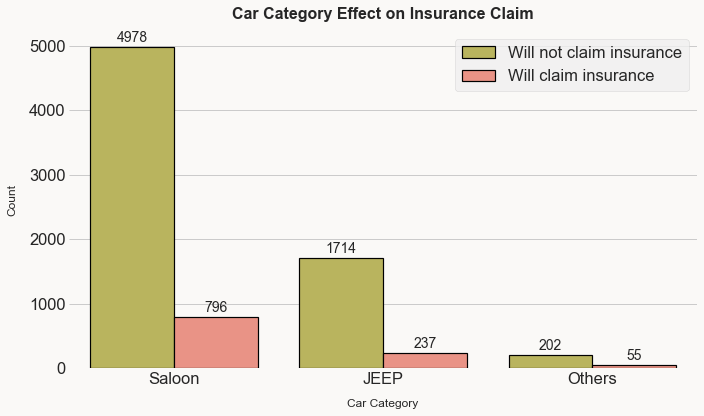

In [3720]:
# Barchart of the different car categories and check the number that claimed insurance and those that did not 
# claim insurance after joining.
fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

bar_pal = ["#c8c14f", "#fa8775"]

s = sns.countplot(
    data = train, x = 'Car_Category', hue = 'target', palette = bar_pal,
    linewidth = 1.2, ec = 'black'
)

for i in ['top', 'right', 'bottom', 'left']:
    ax.spines[i].set_visible(False)

plt.legend(['Will not claim insurance', 'Will claim insurance'])
plt.title("Car Category Effect on Insurance Claim", size = 16, weight = 'bold', pad = 12)
plt.xlabel('Car Category', size = 12, labelpad = 12)
plt.ylabel('Count', size = 12, labelpad = 12)

for i in s.patches:
    s.annotate(format(i.get_height(), '.0f'),  (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

fig.tight_layout()

**Observation**

Out of the 5774 saloon car owners, 4978 saloon car owners will not claim insurance within the first three months from their first transaction while 796 will claim insurance within the first three months of their first transaction. Of the 1951 jeep owners, 1714 will not claim insurance while 237 jeep owners will claim insurance within the first three months of their first transaction.Of the others vehicle category, 202 will not claim insurance while 55 will claim insurance within the first three months of their first transaction.

<p style="text-align:center;"><b>Subject Car Make</b></p>

In [3722]:
# Check the proportion of subject car make
train.Subject_Car_Make.value_counts(normalize=True)

TOYOTA        0.520572
Honda         0.108807
Lexus         0.063844
Mercedes      0.054567
Hyundai       0.045509
                ...   
Tata          0.000109
CHANGAN       0.000109
Raston        0.000109
ZOYTE         0.000109
Rols Royce    0.000109
Name: Subject_Car_Make, Length: 68, dtype: float64

In [3723]:
# Compare the target column to subject car make
pd.crosstab(train.Subject_Car_Make, train.target)

target              0   1
Subject_Car_Make         
.                  27  13
ABG                 1   0
ACURA              57   7
As Attached         5   5
Ashok Leyland       1   0
...               ...  ..
Volkswagen        112   5
Volvo              28   8
Wrangler Jeep       1   0
Yamaha              1   0
ZOYTE               1   0

[68 rows x 2 columns]

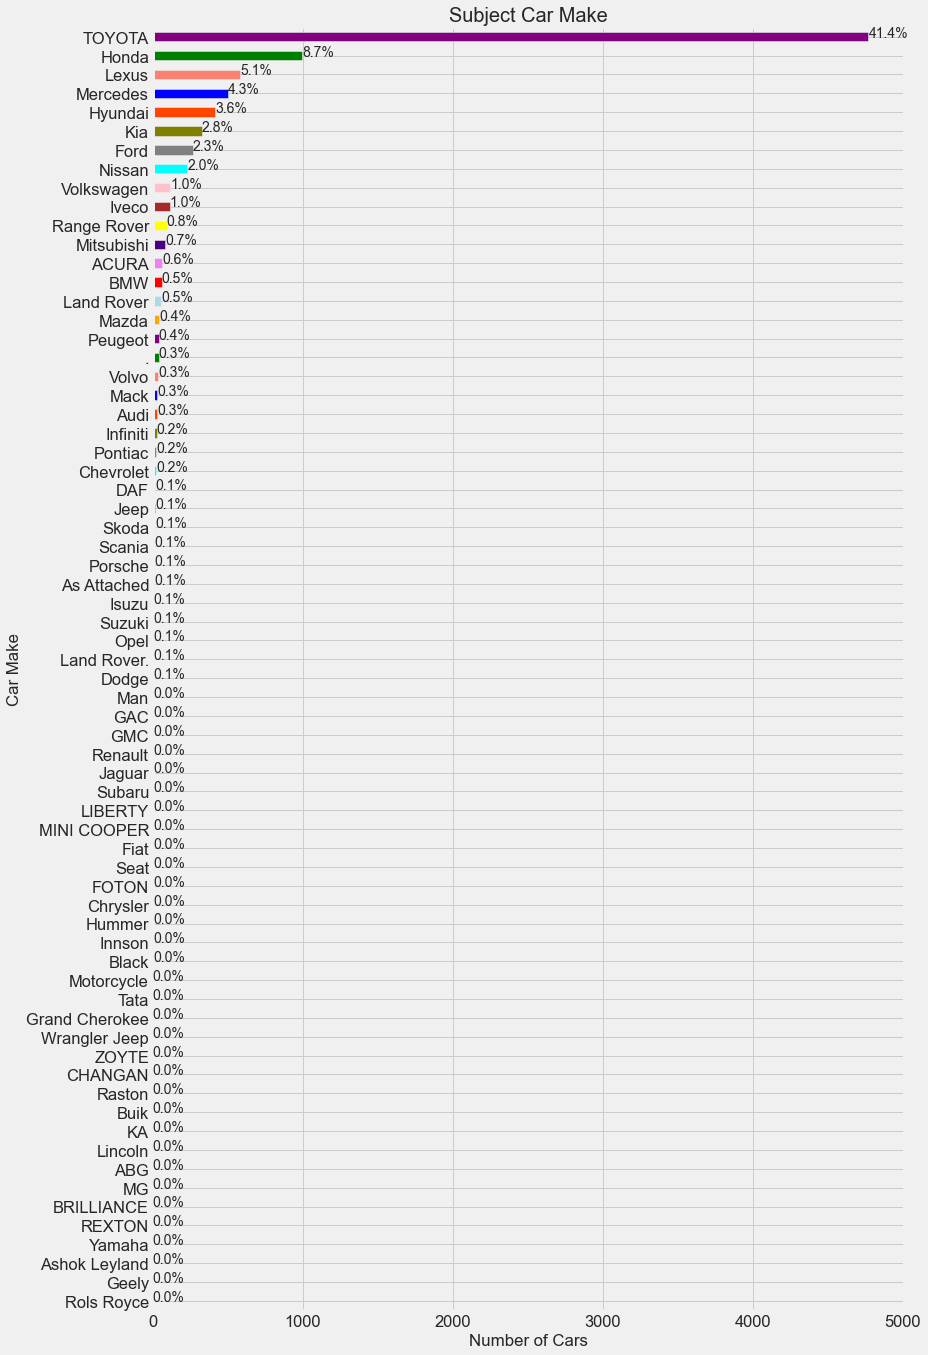

In [3724]:
# Subject car make Distribution before joining
ax = train.Subject_Car_Make.value_counts().sort_values().plot(kind='barh', 
                                                            figsize=(12, 22), 
                                                            color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('Subject Car Make', fontdict={'size': 20})
plt.xlabel('Number of Cars')
plt.ylabel('Car Make')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/train.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

In [3725]:
# Replace subject car make that are less than 200 with others
mapper = {'Range Rover':'Others', 'Mitsubishi':'Others', 'ACURA':'Others', 'BMW': 'Others', 'Land Rover':"Others", 'Mazda': 'Others', 
          'Peugeot':'Others', '.': 'Others', 'Volvo': 'Others', 'Mack': 'Others', 'Audi': 'Others','Infiniti': 'Others', 
          'Pontiac': 'Others', 'Chevrolet': 'Others', 'DAF': 'Others', 'Skoda': 'Others', 'Jeep': 'Others', 
          'Porsche': 'Others', 'As Attached': 'Others', 'Scania':'Others', 'Suzuki':'Others', 'Opel':'Others', 
          'Isuzu': 'Others', 'Dodge':"Others", 'Renault': 'Others', 'Land Rover.':'Others', 'Subaru':'Others', 'GMC':'Others', 
          'GAC': 'Others', 'Man':"Others", 'LIBERTY': 'Others', 'MINI COOPER': 'Others', 'Jaguar': 'Others', 'Wrangler Jeep': 'Others',
          'Hummer': 'Others', 'Chrysler': 'Others', 'Fiat': 'Others', 'Grand Cherokee': 'Others', 'Astra': 'Others', 'Innson':'Others',
          'Seat': 'Others', 'Black': 'Others', 'FOTON':'Others', 'Datsun': 'Others', 'Geely':'Others', 'Yamaha': 'Others', 'ABG': 'Others',
          'REXTON': 'Others', 'ZOYTE': 'Others', 'CHANGAN':'Others', 'BRILLIANCE': 'Others', 'Motorcycle': 'Others', 'Raston':'Others',
          'COMMANDER':'Others', 'Jincheng':'Others', 'Caddillac':'Others', 'Buik':'Others', 'Rols Royce':'Others', 'KA': 'Others',
          'Howo': 'Others', 'Lincoln':'Others', 'Tata':'Others', 'Ashok Leyland':'Others', 'MG':'Others', 'Bajaj':'Others',
          'Volkswagen':'Others', 'Iveco': 'Others'}
train.Subject_Car_Make = train.Subject_Car_Make.replace(mapper)

# Confirm mappings
train.Subject_Car_Make.value_counts(normalize=True)

TOYOTA      0.520572
Others      0.116556
Honda       0.108807
Lexus       0.063844
Mercedes    0.054567
Hyundai     0.045509
Kia         0.035578
Ford        0.029248
Nissan      0.025319
Name: Subject_Car_Make, dtype: float64

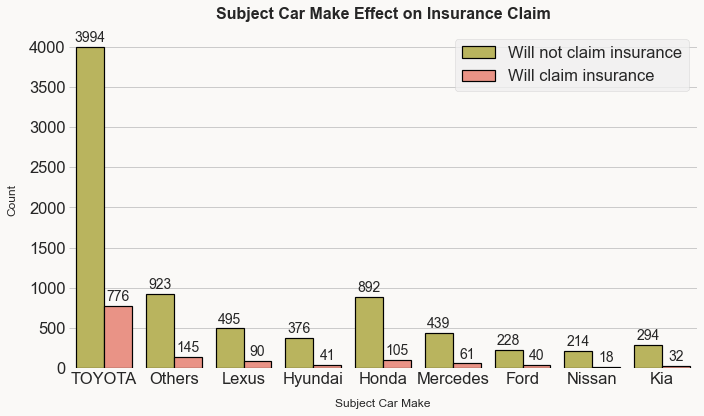

In [3728]:
# Plot a barchart of the different car make and check the number that claimed 
# insurance and those that did not claim insurance after joining.
fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

bar_pal = ["#c8c14f", "#fa8775"]

s = sns.countplot(
    data = train, x = 'Subject_Car_Make', hue = 'target', palette = bar_pal,
    linewidth = 1.2, ec = 'black'
)

for i in ['top', 'right', 'bottom', 'left']:
    ax.spines[i].set_visible(False)

plt.legend(['Will not claim insurance', 'Will claim insurance'])
plt.title("Subject Car Make Effect on Insurance Claim", size = 16, weight = 'bold', pad = 12)
plt.xlabel('Subject Car Make', size = 12, labelpad = 12)
plt.ylabel('Count', size = 12, labelpad = 12)

for i in s.patches:
    s.annotate(format(i.get_height(), '.0f'),  (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 9), textcoords = 'offset points')

fig.tight_layout()

**Observation**

Out of the 4770 toyota car owners, 3994 toyota car owners will not claim insurance within the first three months from their first transaction while 776 will claim insurance within the first three months of their first transaction. For the others vehicle category, there are a total of 1068 car owners of differenct car types, out of the 1068 others car make, 923 will not claim insurance while 145 will claim insurance within the first three months of their first transaction.Of the 585 lexus owners, 495 will not claim insurance while 90 lexus owners will claim insurance within the first three months of their first transaction. Out of the 417 hyundai car owners, 376 will not claim insurance while 41 hyundai car owners will claim insurance. There are a total of 997 honda car owners, out of the 997 honda owners, 892 will not claim insurance while 105 will claim insurance. Out of the 500 mercedes benz owners, 439 will not claim insurance within the first three months of their first transaction while 61 will claim insurance within the first three months of their first trasaction. Out of the 268 ford owners, 228 will not claim insurance within the first three months of their first transaction while 40 will claim insurance within the first three months of their first transaction. Of the 232 nissan car owners, 214 will not claim insurance within the first three months of their first transaction while 18 will claim insurance within the first three months of their first transaction. There are a total of 326 kia car owners, 294 will not claim insurance within the first three months while 32 will claim insurance within the first three months.

<p style="text-align:center;"><b>STATE</b></p>

In [3729]:
# Check the proportion of state
train.State.value_counts(normalize=True)

Lagos              0.567426
Benue              0.114120
Eti-Osa            0.040157
Abuja-Municipal    0.035487
Ibeju-Lekki        0.022600
                     ...   
Ogba-Ndoni         0.000187
Essien-Udim        0.000187
Ughelli-North      0.000187
Asari-Toru         0.000187
Ovia-SouthWest     0.000187
Name: State, Length: 111, dtype: float64

In [3730]:
# Compare the target column to State
pd.crosstab(train.State, train.target)

target          0  1
State               
ABULE-EGBA      5  1
AJAO-ESTATE     2  0
Aba-North       3  0
Aba-South       1  0
Abia            2  0
...            .. ..
Ughelli-North   1  0
Umuahia-South   2  0
Warri-Central  23  4
Warri-North     3  0
Warri-South     2  0

[111 rows x 2 columns]

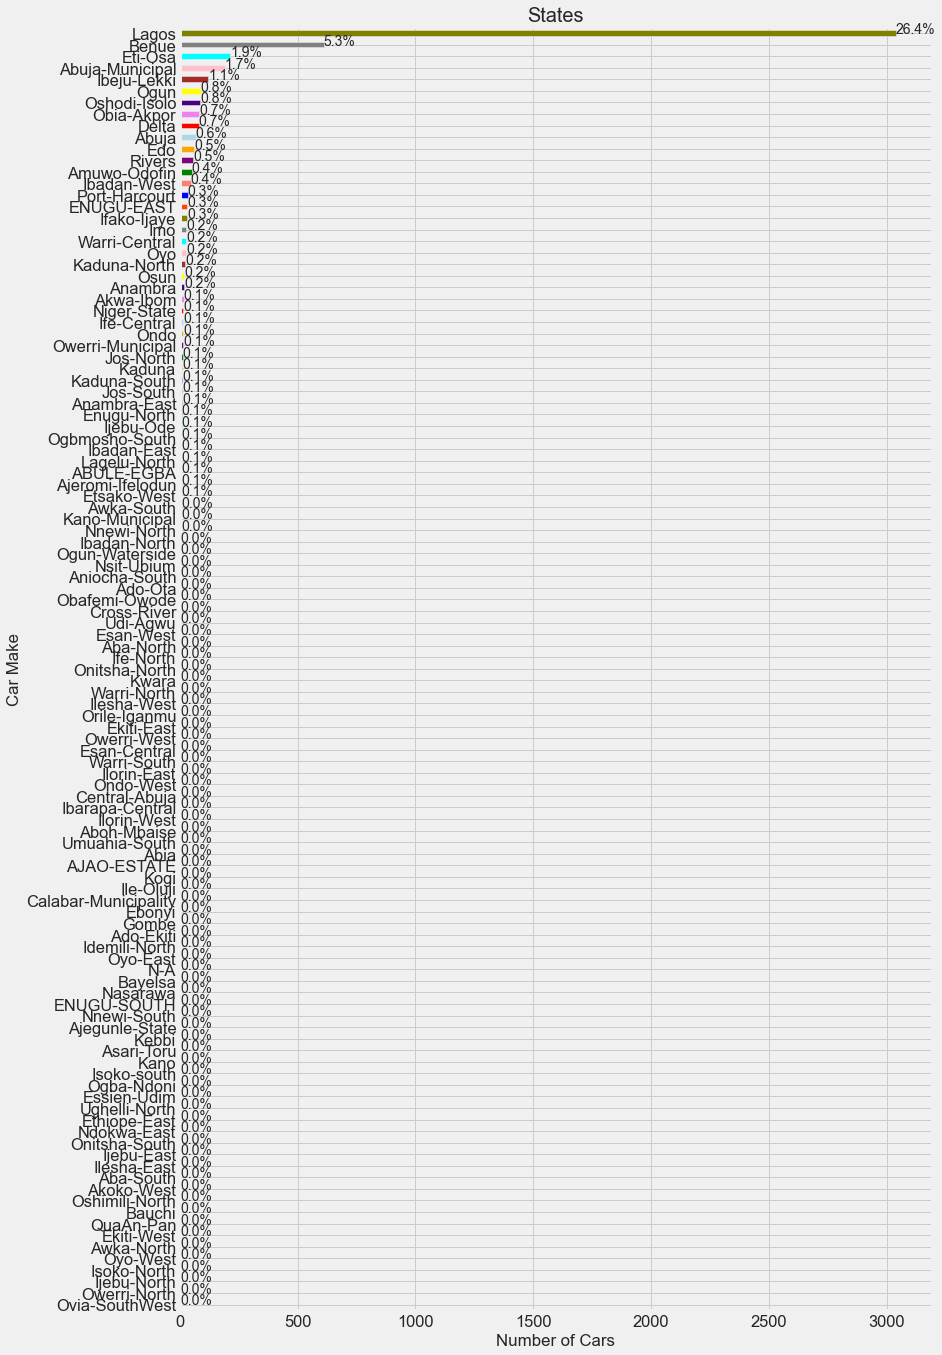

In [3731]:
# State Distribution before joining
ax = train.State.value_counts().sort_values().plot(kind='barh', 
                                                            figsize=(12, 22), 
                                                            color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('States', fontdict={'size': 20})
plt.xlabel('Number of Cars')
plt.ylabel('Car Make')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/train.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

In [3732]:
# Replace local governments that are in each states with the actual states
mapper = {'Abuja-Municipal':'Abuja', 'Eti-Osa':'Lagos', 'Ibeju-Lekki':'Lagos', 'Obia-Akpor': 'Rivers', 'Oshodi-Isolo':"Lagos", 'Amuwo-Odofin': 'Lagos', 
          'Ibadan-West':'Oyo', 'Port-Harcourt': 'Rivers', 'Ifako-Ijaye': 'Lagos', 'ENUGU-EAST': 'Enugu', 'Warri-Central': 'Delta','Kaduna-North': 'Kaduna', 
          'Ife-Central': 'Osun', 'Jos-North': 'Plateau', 'Owerri-Municipal': 'Imo', 'Ijebu-Ode': 'Ogun', 'Jos-South': 'Plateau', 
          'Kaduna-South': 'Kaduna', 'Anambra-East': 'Anambra', 'Enugu-North':'Enugu', 'Lagelu-North':'Oyo', 'Ogbmosho-South':'Oyo', 
          'Ibadan-East': 'Oyo', 'Nnewi-North':"Anambra", 'Ibadan-North': 'Oyo', 'Etsako-West':'Edo', 'Ajeromi-Ifelodun':'Lagos', 'ABULE-EGBA':'Lagos', 
          'Kano-Municipal': 'Kano', 'Awka-South':"Anambra", 'Obafemi-Owode': 'Ogun', 'Ilesha-West': 'Osun', 'Nsit-Ubium': 'Akwa-Ibom', 'Aba-North': 'Abia',
          'Aniocha-South': 'Delta', 'Onitsha-North': 'Anambra', 'Ado-Ota': 'Ogun', 'Ogun-Waterside': 'Ogun', 'Esan-West': 'Edo', 'Ife-North':'Osun',
          'Warri-North': 'Delta', 'Ilorin-West': 'Kwara', 'Udi-Agwu':'Enugu', 'AJAO-ESTATE': 'Lagos', 'Onitsha-South':'Anambra', 'Orile-Iganmu': 'Lagos', 'Esan-Central': 'Edo',
          'Ondo-West': 'Ondo', 'Ilorin-East': 'Kwara', 'Idemili-North':'Anambra', 'Ekiti-East': 'Ekiti', 'Warri-South': 'Delta', 'Oyo-East':'Oyo',
          'Aboh-Mbaise':'Imo', 'Ado-Ekiti':'Ekiti', 'Central-Abuja':'Abuja', 'Ibarapa-Central':'Oyo', 'Ile-Oluji':'Ondo', 'Owerri-West': 'Imo',
          'Calabar-Municipality': 'Cross-River', 'Umuahia-South':'Abia', 'QuaAn-Pan':'Plateau', 'Ogba-Ndoni':'Rivers', 'Awka-North':'Anambra', 'Aba-South':'Abia',
          'Ekiti-West':'Ekiti', 'Ughelli-North': 'Delta', 'Isoko-North': 'Delta', 'Asari-Toru': 'Rivers', 'Ndokwa-East':'Delta', 'Idemili-south':'Anambra', 'Ethiope-East':'Delta', 
          'Oyo-West': 'Oyo', 'Oshimili-North':"Delta", 'Ngor-Okpala': 'Imo', 'Ilesha-East':'Osun', 'Nnewi-South':'Anambra', 'Essien-Udim':'Akwa-Ibom', 
          'Owerri-North': 'Imo', 'Ajegunle-State':"Lagos", 'Isoko-south': 'Delta', 'Akoko-West': 'Ondo', 'Ijebu-East': 'Ogun', 'ENUGU-SOUTH': 'Enugu',
          'Ijebu-North': 'Ogun', 'N-A': 'Kano', 'Ovia-SouthWest': 'Edo', 'Akwa Ibom': 'Akwa-Ibom', 'Cross River': 'Cross-River', 'Cross Rivers': 'Cross-River'}
train.State = train.State.replace(mapper)

# Confirm mappings
train.State.value_counts()

Lagos          3560
Benue           611
Abuja           260
Rivers          177
Delta           122
Ogun            110
Oyo             102
Edo              74
Anambra          46
Imo              45
Kaduna           44
Enugu            44
Osun             39
Plateau          23
Akwa-Ibom        22
Ondo             18
Niger-State      14
Abia              8
Kano              7
Kwara             7
Cross-River       6
Ekiti             5
Ebonyi            2
Kogi              2
Gombe             2
Kebbi             1
Bauchi            1
Nasarawa          1
Bayelsa           1
Name: State, dtype: int64

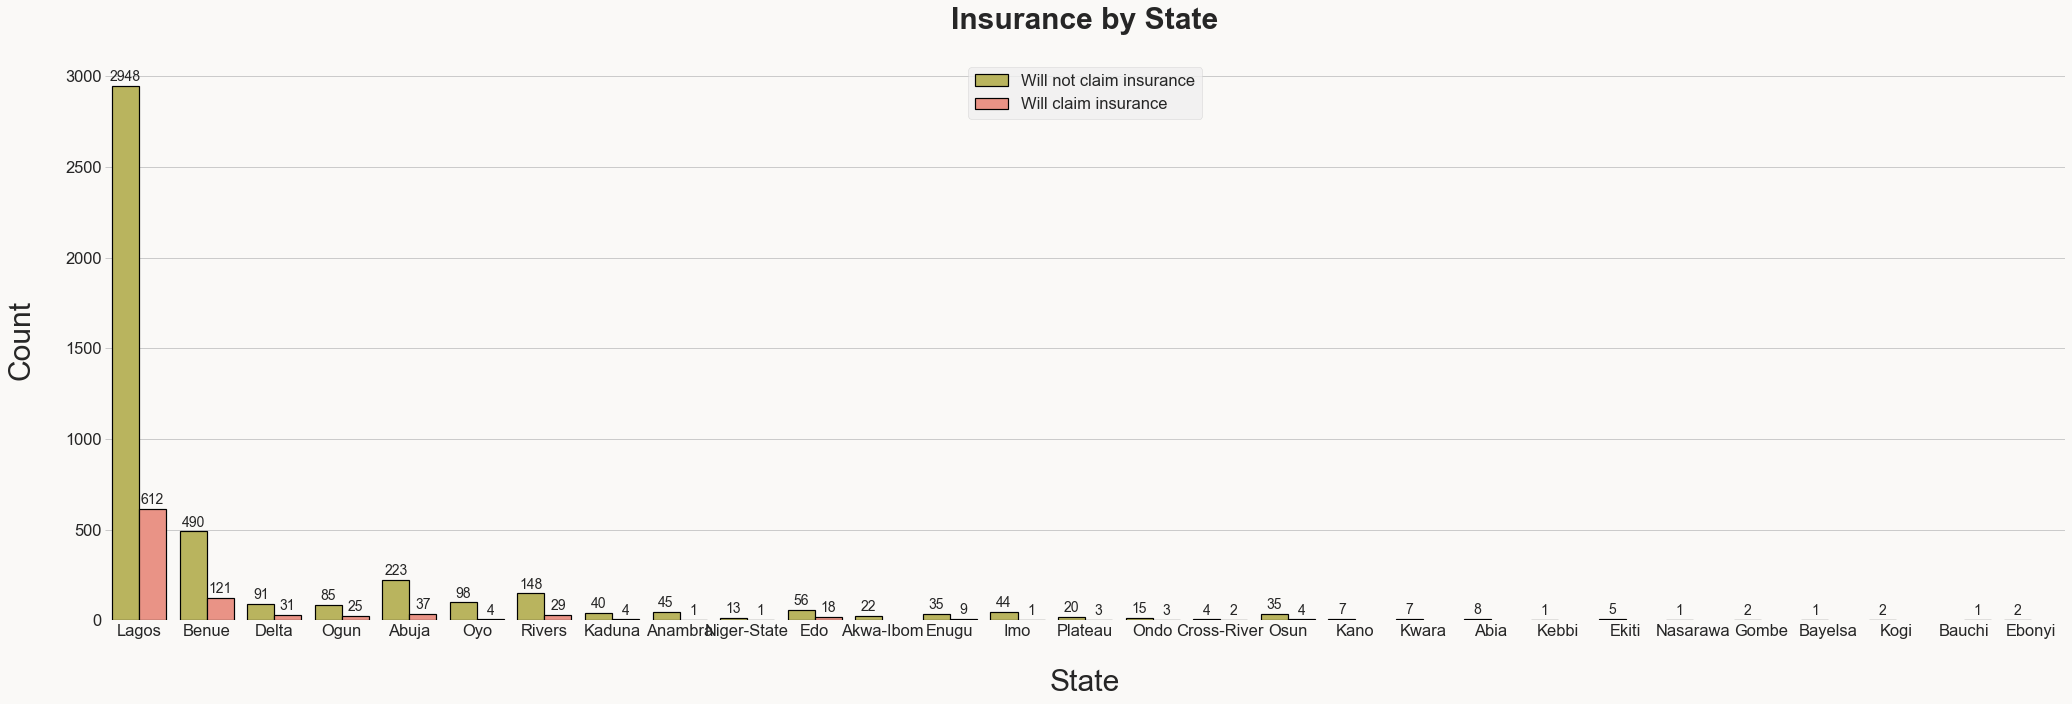

In [3735]:
# Plot a barchart of the different states and check the number that claimed 
# insurance and those that did not claim insurance after joining.
fig, ax = plt.subplots(figsize=(29,10))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

bar_pal = ["#c8c14f", "#fa8775"]

s = sns.countplot(
    data = train, x = 'State', hue = 'target', palette = bar_pal,
    linewidth = 1.2, ec = 'black'
)

for i in ['top', 'right', 'bottom', 'left']:
    ax.spines[i].set_visible(False)

plt.legend(['Will not claim insurance', 'Will claim insurance'], loc = 'upper center')
plt.title("Insurance by State", size = 30, weight = 'bold', pad = 30)
plt.xlabel('State', size = 30, labelpad = 30)
plt.ylabel('Count', size = 30, labelpad = 30)

for i in s.patches:
    s.annotate(format(i.get_height(), '.0f'),  (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 9), textcoords = 'offset points')

fig.tight_layout()

<p style="text-align:center;"><b>LGA NAMES</b></p>

In [3736]:
train.LGA_Name.value_counts()

Victoria Island          1098
Ikeja                     391
Surulere                  279
Lagos Mainland            216
Eti-Osa                   215
                         ... 
Oyo West                    1
Isoko south                 1
Ajegunle,Lagos  State       1
Isoko North                 1
Kuje                        1
Name: LGA_Name, Length: 256, dtype: int64

In [3737]:
# Compare the target column to State
pd.crosstab(train.LGA_Name, train.target)

target        0  1
LGA_Name          
 IFAKO        1  1
ABULE EGBA    5  1
AJAO ESTATE   2  0
AKUTE         2  3
ALAPERE       3  0
...          .. ..
Yaba         34  4
Yenagoa       1  0
Yorro         1  0
Zaria         2  0
kumbotso      1  0

[256 rows x 2 columns]

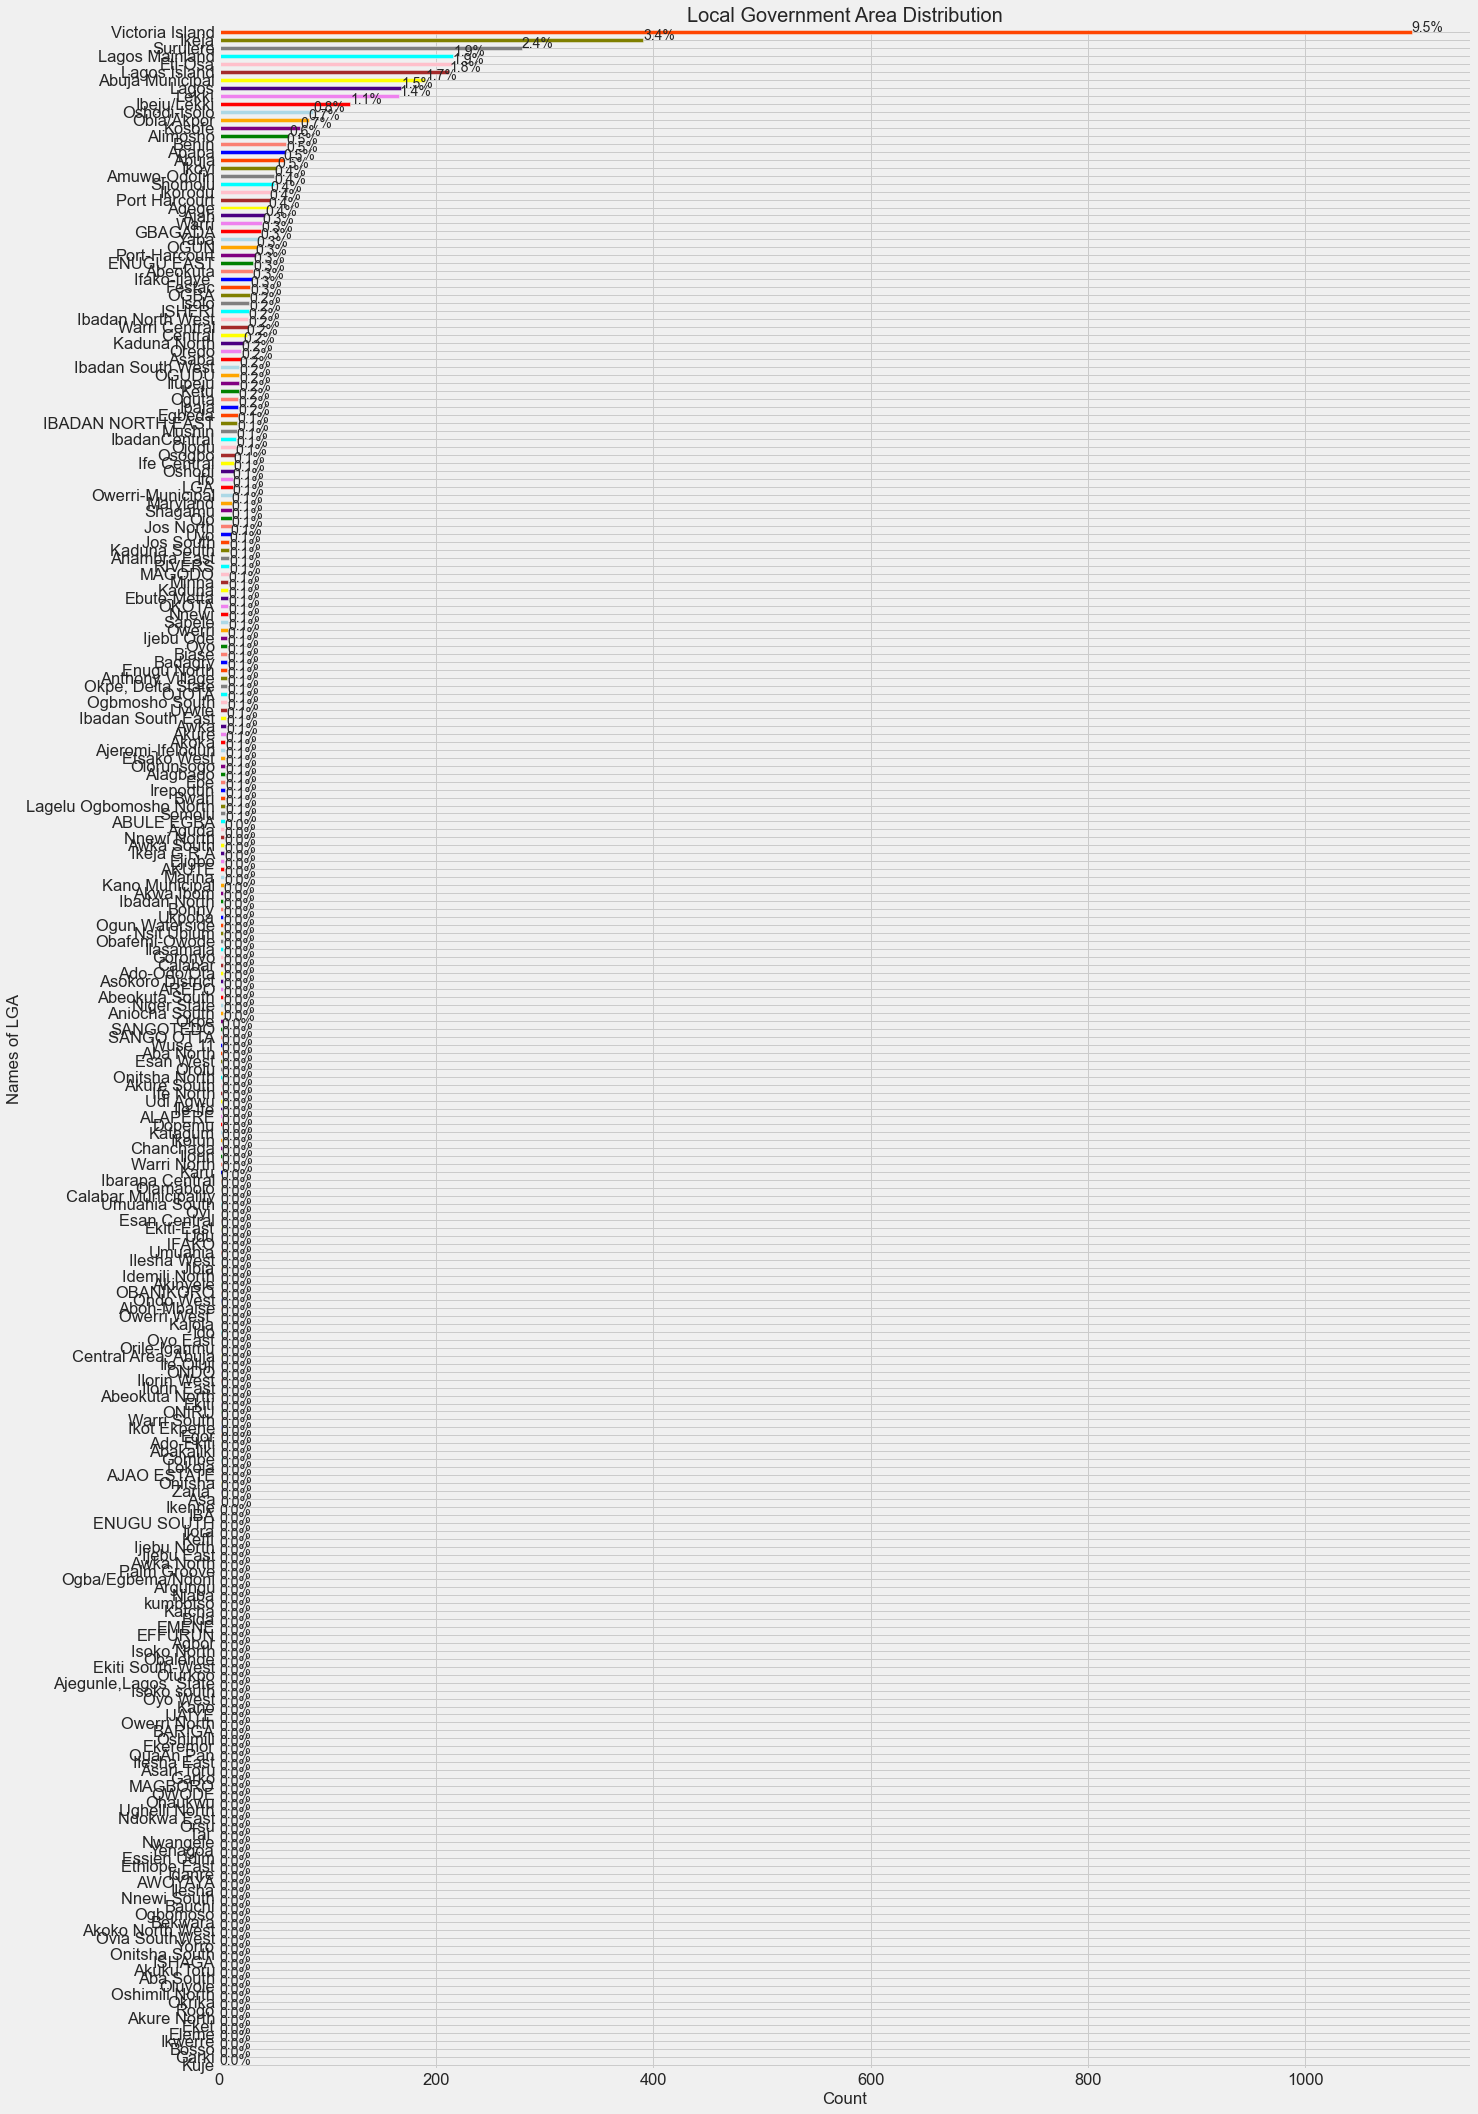

In [3738]:
# LGA Names Distribution
ax = train.LGA_Name.value_counts().sort_values().plot(kind='barh', 
                                                            figsize=(20, 35), 
                                                            color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('Local Government Area Distribution', fontdict={'size': 20})
plt.xlabel('Count')
plt.ylabel('Names of LGA')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/train.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

<p style="text-align:center;"><b>Product Name</b></p>

In [3739]:
train.ProductName.value_counts()

Car Classic         6297
CarSafe             3524
Customized Motor     498
Car Plus             469
CVTP                 412
CarFlex              176
Muuve                 92
Motor Cycle           38
Car Vintage            5
Name: ProductName, dtype: int64

In [3740]:
# Compare the target column to State
pd.crosstab(train.ProductName, train.target)

target               0     1
ProductName                 
CVTP               310   102
Car Classic       5250  1047
Car Plus           374    95
Car Vintage          5     0
CarFlex            147    29
CarSafe           3511    13
Customized Motor   457    41
Motor Cycle         31     7
Muuve               27    65

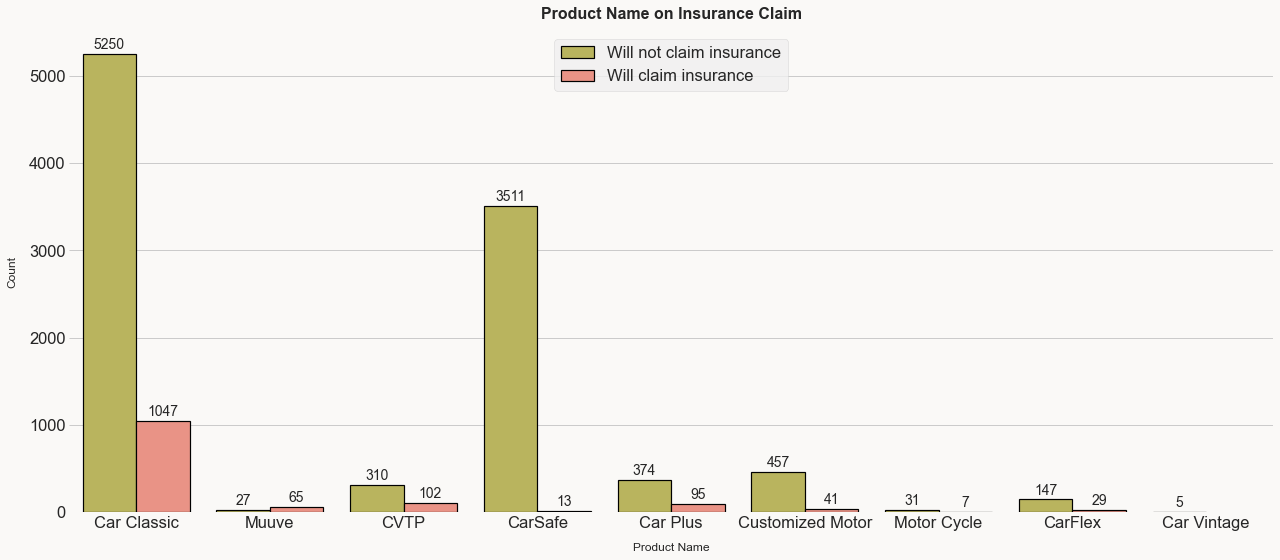

In [3741]:
# Plot a barchart of the different product name and check the number that claimed 
# insurance and those that did not claim insurance.
fig, ax = plt.subplots(figsize=(18,8))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

bar_pal = ["#c8c14f", "#fa8775"]

s = sns.countplot(
    data = train, x = 'ProductName', hue = 'target', palette = bar_pal,
    linewidth = 1.2, ec = 'black'
)

for i in ['top', 'right', 'bottom', 'left']:
    ax.spines[i].set_visible(False)

plt.legend(['Will not claim insurance', 'Will claim insurance'])
plt.title("Product Name on Insurance Claim", size = 16, weight = 'bold', pad = 12)
plt.xlabel('Product Name', size = 12, labelpad = 12)
plt.ylabel('Count', size = 12, labelpad = 12)

for i in s.patches:
    s.annotate(format(i.get_height(), '.0f'),  (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 9), textcoords = 'offset points')

fig.tight_layout()

**Observation**

Out of the 6297 customers that regstered for Car Classic insurance policy, 5250 Car Classic Customers will not claim insurance within the first three months from their first transaction while 1047 will claim insurance within the first three months of their first transaction. For the Muuve insurance policy, there are a total of 92 customers that registered for the Muuve insurance, out of the 92 Muuve customers, 27 will not claim insurance while 65 will claim insurance within the first three months of their first transaction.Of the 412 customers that registered for CVTP insurance policy, 310 will not claim insurance while 102 customers will claim insurance within the first three months of their first transaction. Out of the 3524 customers that registered for CarSafe insurance policy, 3511 will not claim insurance while 13 CarSafe insurance policy holders will claim insurance. There are a total of 469 CarPlus insurance policy holders, out of the 469 CarPlus insurance policy  holders, 374 will not claim insurance while 95 will claim insurance. Out of the 489 Customized motor insurance policy holders, 457 customized motor insurance policy holders will not claim insurance within the first three months of their first transaction while 41 will claim insurance within the first three months of their first trasaction. Out of the 28 motorcycle insurance policy holders, 31 will not claim insurance within the first three months of their first transaction while 7 will claim insurance within the first three months of their first transaction. Of the 176 CarFlex insurance policy holders, 147 will not claim insurance within the first three months of their first transaction while 29 will claim insurance within the first three months of their first transaction. There are a total of 5 Car Vintage insurance policy holders, all 5 of them will not claim insurance within the first three months.

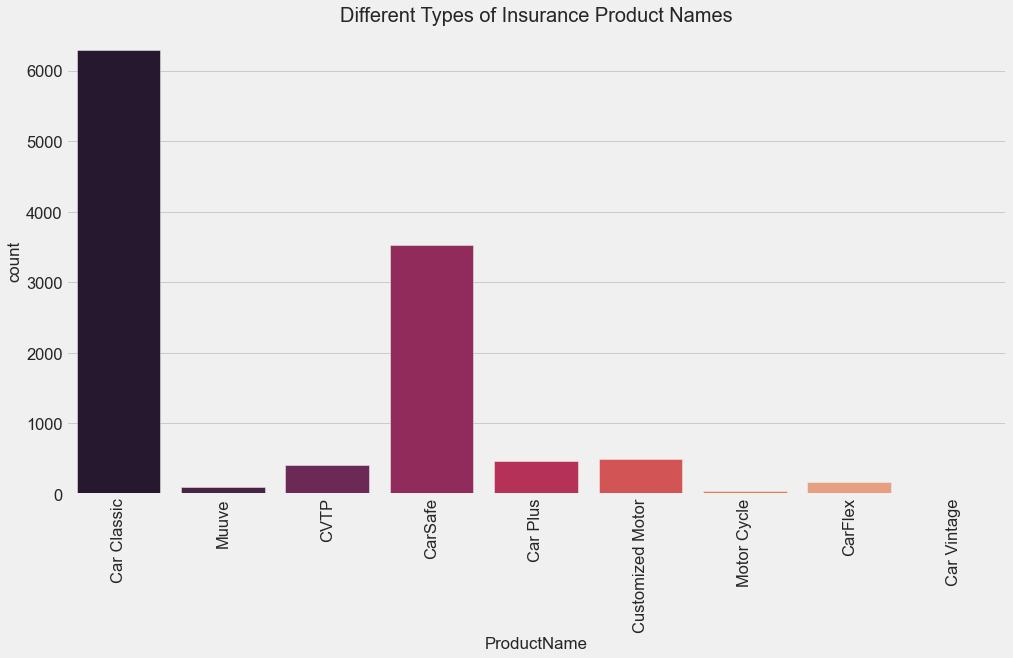

In [3743]:
# let's visualize the different product names

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)

sns.countplot(train['ProductName'], palette = 'rocket')
plt.title('Different Types of Insurance Product Names', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

In [3744]:
# Let's see how many positive (1) and negative (0) samples we have in our dataframe
print('Length of the training dataset:', len(train))
print('Total no of customers that will not claim insurance in the first 3 months:', len(train[train['target']==0]))
print('Total no of customers that will claim insurance in the first 3 months:', len(train[train['target']==1]))

Length of the training dataset: 11511
Total no of customers that will not claim insurance in the first 3 months: 10112
Total no of customers that will claim insurance in the first 3 months: 1399


In [3745]:
# Check the shape of the training dataset
print(f'The shape of the training dataset is: {train.shape}')

The shape of the training dataset is: (11511, 14)


In [3746]:
# Check the proportion of the classes in the target column
train['target'].value_counts(normalize=True)

0    0.878464
1    0.121536
Name: target, dtype: float64

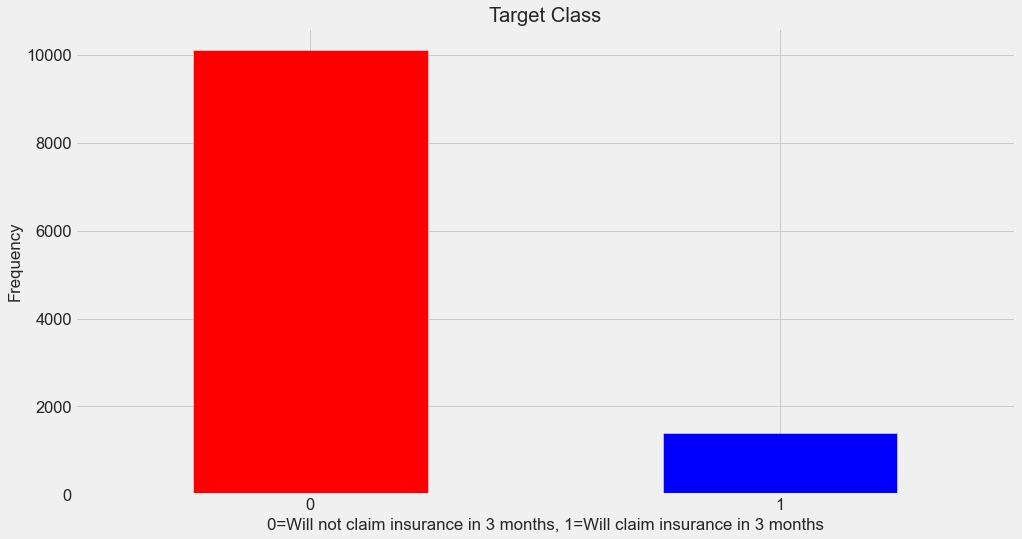

In [3747]:
# Plot the target value counts with a bar graph
train.target.value_counts().plot(kind='bar', title = 'Target Class', color=['red', 'blue'])
plt.xlabel('0=Will not claim insurance in 3 months, 1=Will claim insurance in 3 months')
plt.ylabel('Frequency')
plt.xticks(rotation=0);

In [3748]:
# Check if there are any missing values
train.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     996
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              3529
Subject_Car_Colour        6568
Subject_Car_Make          2348
LGA_Name                  6145
State                     6157
ProductName                  0
target                       0
dtype: int64

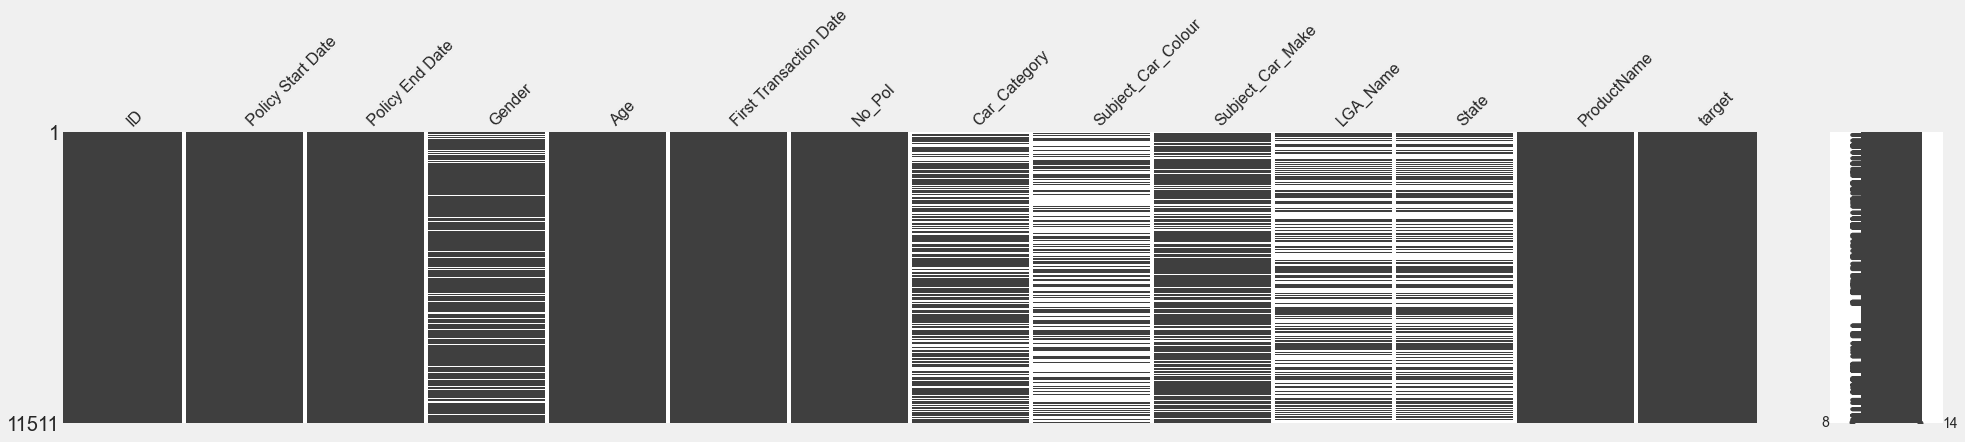

In [3749]:
# Visualizing the missing values in the dataset
missingno.matrix(train, figsize=(30, 5));

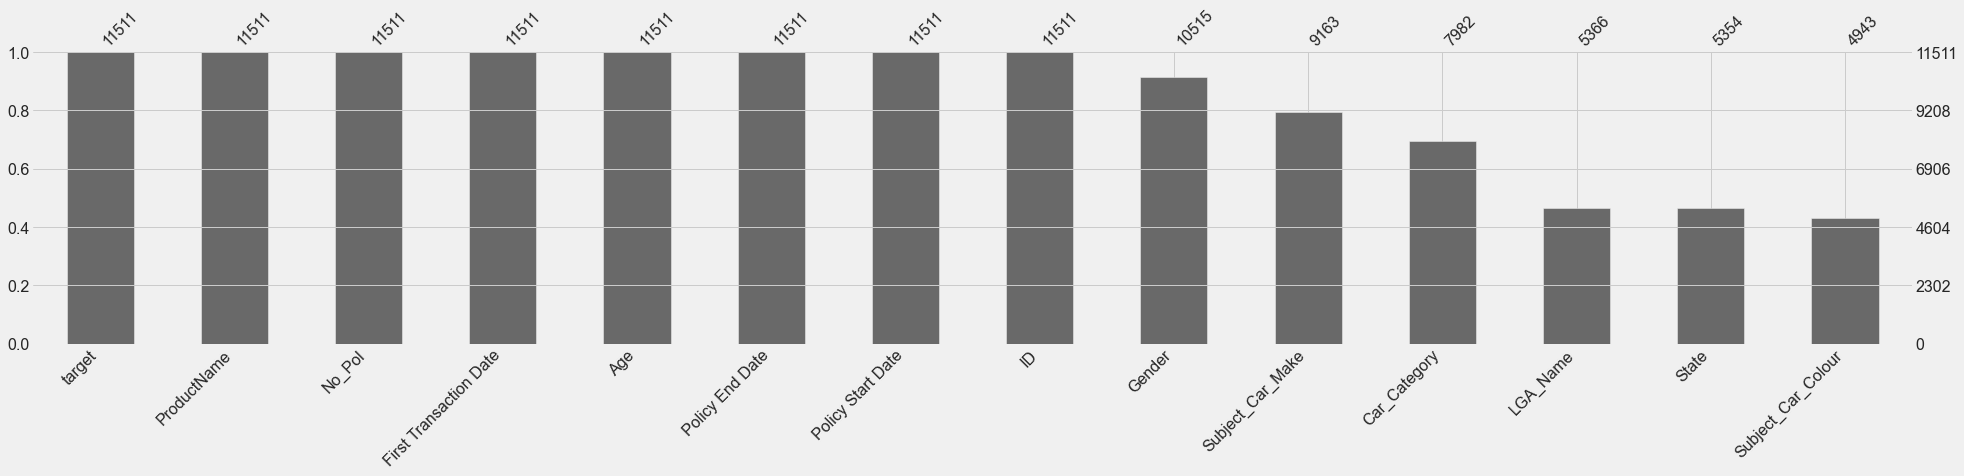

In [3750]:
# Visualize the missing values in descending order
missingno.bar(train, sort='descending', figsize=(30, 5));

In [3751]:
# check dtype of "Policy_Start_Date, Policy_End_Date, First_Transaction_Date"
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11511 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      11511 non-null  object        
 1   Policy Start Date       11511 non-null  datetime64[ns]
 2   Policy End Date         11511 non-null  datetime64[ns]
 3   Gender                  10515 non-null  object        
 4   Age                     11511 non-null  int64         
 5   First Transaction Date  11511 non-null  datetime64[ns]
 6   No_Pol                  11511 non-null  int64         
 7   Car_Category            7982 non-null   object        
 8   Subject_Car_Colour      4943 non-null   object        
 9   Subject_Car_Make        9163 non-null   object        
 10  LGA_Name                5366 non-null   object        
 11  State                   5354 non-null   object        
 12  ProductName             11511 non-null  object

We've turned the `PolicyStartDate`, `PolicyEndDate`, `FirstTransactionDate` column from object datatype to datetime64 datatype.

In [3752]:
train.head().T

0                    1  \
ID                               ID_0040R73           ID_0046BNK   
Policy Start Date       2010-05-14 00:00:00  2010-11-29 00:00:00   
Policy End Date         2011-05-13 00:00:00  2011-11-28 00:00:00   
Gender                                 Male               Female   
Age                                      30                   79   
First Transaction Date  2010-05-14 00:00:00  2010-11-29 00:00:00   
No_Pol                                    1                    1   
Car_Category                         Saloon                 JEEP   
Subject_Car_Colour                    Black                 Grey   
Subject_Car_Make                     TOYOTA               TOYOTA   
LGA_Name                                NaN                  NaN   
State                                   NaN                  NaN   
ProductName                     Car Classic          Car Classic   
target                                    0                    1   

                                          2                    4  \
ID                               ID_005QMC3           ID_00BRP63   
Policy Start Date       2010-03-21 00:00:00  2010-08-29 00:00:00   
Policy End Date         2011-03-20 00:00:00  2010-12-31 00:00:00   
Gender                                 Male                  NaN   
Age                                      43                   20   
First Transaction Date  2010-03-21 00:00:00  2010-08-29 00:00:00   
No_Pol                                    1                    3   
Car_Category                         Saloon                  NaN   
Subject_Car_Colour                      Red                  NaN   
Subject_Car_Make                     TOYOTA                  NaN   
LGA_Name                                NaN                Lagos   
State                                   NaN                Lagos   
ProductName                     Car Classic                Muuve   
target                                    0                    1   

                                          5  
ID                               ID_00D3EF6  
Policy Start Date       2010-10-21 00:00:00  
Policy End Date         2011-10-20 00:00:00  
Gender                                 Male  
Age                                      37  
First Transaction Date  2010-10-21 00:00:00  
No_Pol                                    2  
Car_Category                            NaN  
Subject_Car_Colour                      NaN  
Subject_Car_Make                        NaN  
LGA_Name                                NaN  
State                                   NaN  
ProductName                     Car Classic  
target                                    0

## **4. Feature Engineering**

<a id="features"></a>

**Engineering**: There are multiple techniques for feature engineering:

* **Decompose**: Converting 2014-09-20T20:45:40Z into categorical attributes like hour_of_the_day, part_of_day, etc.

**Imputation**: We can impute missing values in a number of different ways:

* **Hot-Deck**: The technique then finds the first missing value and uses the cell value immediately prior to the data that are missing to impute the missing value.
* **Cold-Deck**: Selects donors from another dataset to complete missing data.
* **Mean-substitution**: Another imputation technique involves replacing any missing value with the mean of that variable for all other cases, which has the benefit of not changing the sample mean for that variable.
* **Regression**: A regression model is estimated to predict observed values of a variable based on other variables, and that model is then used to impute values in cases where that variable is missing.

In [3753]:
train['Policy Start Date']

0       2010-05-14
1       2010-11-29
2       2010-03-21
4       2010-08-29
5       2010-10-21
           ...    
12074   2010-05-25
12075   2010-10-03
12076   2010-10-10
12077   2010-02-27
12078   2010-07-01
Name: Policy Start Date, Length: 11511, dtype: datetime64[ns]

In [3754]:
train['Policy End Date']

0       2011-05-13
1       2011-11-28
2       2011-03-20
4       2010-12-31
5       2011-10-20
           ...    
12074   2011-05-24
12075   2011-10-02
12076   2011-10-08
12077   2011-02-26
12078   2011-06-30
Name: Policy End Date, Length: 11511, dtype: datetime64[ns]

In [3755]:
train['First Transaction Date']

0       2010-05-14
1       2010-11-29
2       2010-03-21
4       2010-08-29
5       2010-10-21
           ...    
12074   2010-05-25
12075   2010-10-03
12076   2010-10-10
12077   2010-02-27
12078   2010-07-01
Name: First Transaction Date, Length: 11511, dtype: datetime64[ns]

### Sort DataFrame by Policy Start Date, Policy End Date and First Transaction Date

In [3756]:
# Sort DataFrame in date order
train.sort_values(by=['Policy Start Date'], inplace=True, ascending=True)
train['Policy Start Date'].head()

8010    2001-12-11
10526   2002-03-25
10234   2003-04-13
12066   2003-12-21
8124    2005-08-05
Name: Policy Start Date, dtype: datetime64[ns]

In [3757]:
# Sort DataFrame in date order
train.sort_values(by=['Policy End Date'], inplace=True, ascending=True)
train['Policy End Date'].head()

11738   2010-12-31
6996    2010-12-31
6050    2010-12-31
4778    2010-12-31
11110   2010-12-31
Name: Policy End Date, dtype: datetime64[ns]

In [3758]:
# Sort DataFrame in date order
train.sort_values(by=['First Transaction Date'], inplace=True, ascending=True)
train['First Transaction Date'].head()

8010    2001-12-11
10526   2002-03-25
10234   2003-04-13
12066   2003-12-21
8124    2005-08-05
Name: First Transaction Date, dtype: datetime64[ns]

In [3759]:
train.head()

ID Policy Start Date Policy End Date  Gender  Age  \
8010   ID_O51ZQ1B        2001-12-11      2011-12-10  Female   37   
10526  ID_VJ1FAVO        2002-03-25      2011-03-24    Male   37   
10234  ID_ULWS8VL        2003-04-13      2011-04-12    Male   41   
12066  ID_ZYKGSP7        2003-12-21      2034-05-20    Male   48   
8124   ID_OEWBKGF        2005-08-05      2011-09-29  Female   44   

      First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
8010              2001-12-11       1       Saloon              Black   
10526             2002-03-25       1       Saloon              Black   
10234             2003-04-13       2       Saloon              Black   
12066             2003-12-21       2       Saloon                NaN   
8124              2005-08-05       1          NaN                NaN   

      Subject_Car_Make LGA_Name  State  ProductName  target  
8010             Honda      NaN    NaN  Car Vintage       0  
10526           TOYOTA    Ekiti  Benue  Car Classic       0  
10234           TOYOTA    Ikeja  Lagos  Car Vintage       0  
12066           Others      NaN    NaN  Car Vintage       0  
8124            Others     Ajah  Lagos         CVTP       0

### Add datetime parameters for PolicyStartDate, PolicyEndDate, FirstTransactionDate column

Why?

So we can enrich our dataset with as much information as possible.

Because we imported the data using `train_csv()` and we asked pandas to parse the dates using parse_dates=[`'PolicyStartDate'`, `'PolicyEndDate'`, `'FirstTransactionDate'`]), we can now access the different [datetime attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) of the date column.

In [3760]:
# Add datetime for Policy Start Date
train['PolicyStartYear'] = train['Policy Start Date'].dt.year
train['PolicyStartMonth'] = train['Policy Start Date'].dt.month
train['PolicyStartDay'] = train['Policy Start Date'].dt.day
train['PolicyStartDayofweek'] = train['Policy Start Date'].dt.dayofweek
train['PolicyStartDayofyear'] = train['Policy Start Date'].dt.dayofyear

# Drop original PolicyStartDate
train.drop("Policy Start Date", axis=1, inplace=True)

In [3761]:
# Add datetime for Policy End Date
train['PolicyEndYear'] = train['Policy End Date'].dt.year
train['PolicyEndMonth'] = train['Policy End Date'].dt.month
train['PolicyEndDay'] = train['Policy End Date'].dt.day
train['PolicyEndDayofweek'] = train['Policy End Date'].dt.dayofweek
train['PolicyEndDayofyear'] = train['Policy End Date'].dt.dayofyear

# Drop original PolicyEndDate
train.drop("Policy End Date", axis=1, inplace=True)

In [3762]:
# Add datetime for FirstTransactionDate
train['FirstTransactionYear'] = train['First Transaction Date'].dt.year
train['FirstTransactionMonth'] = train['First Transaction Date'].dt.month
train['FirstTransactionDay'] = train['First Transaction Date'].dt.day
train['FirstTransactionDayofweek'] = train['First Transaction Date'].dt.dayofweek
train['FirstTransactionDayofyear'] = train['First Transaction Date'].dt.dayofyear

# Drop original FirstTransactionDate
train.drop("First Transaction Date", axis=1, inplace=True)

In [3763]:
train.reset_index(drop=True)

ID  Gender  Age  No_Pol Car_Category Subject_Car_Colour  \
0      ID_O51ZQ1B  Female   37       1       Saloon              Black   
1      ID_VJ1FAVO    Male   37       1       Saloon              Black   
2      ID_ULWS8VL    Male   41       2       Saloon              Black   
3      ID_ZYKGSP7    Male   48       2       Saloon                NaN   
4      ID_OEWBKGF  Female   44       1          NaN                NaN   
...           ...     ...  ...     ...          ...                ...   
11506  ID_SAFB882    Male   48       1          NaN                NaN   
11507  ID_S6CWED4    Male   37       1          NaN                NaN   
11508  ID_ZMXI8LN    Male   36       1          NaN                NaN   
11509  ID_85P2ABI    Male   66       1       Saloon                NaN   
11510  ID_MLGO8DZ    Male   51       4       Saloon              Black   

      Subject_Car_Make         LGA_Name  State  ProductName  ...  \
0                Honda              NaN    NaN  Car Vintage  ...   
1               TOYOTA            Ekiti  Benue  Car Classic  ...   
2               TOYOTA            Ikeja  Lagos  Car Vintage  ...   
3               Others              NaN    NaN  Car Vintage  ...   
4               Others             Ajah  Lagos         CVTP  ...   
...                ...              ...    ...          ...  ...   
11506              NaN              NaN    NaN      CarSafe  ...   
11507              NaN              NaN    NaN  Car Classic  ...   
11508              NaN              NaN    NaN      CarSafe  ...   
11509           TOYOTA              NaN    NaN      CarSafe  ...   
11510            Honda  Victoria Island  Lagos  Car Classic  ...   

       PolicyEndYear  PolicyEndMonth  PolicyEndDay  PolicyEndDayofweek  \
0               2011              12            10                   5   
1               2011               3            24                   3   
2               2011               4            12                   1   
3               2034               5            20                   5   
4               2011               9            29                   3   
...              ...             ...           ...                 ...   
11506           2011              12            30                   4   
11507           2011              12            30                   4   
11508           2011              12            29                   3   
11509           2011              12            30                   4   
11510           2011               6            30                   3   

       PolicyEndDayofyear  FirstTransactionYear  FirstTransactionMonth  \
0                     344                  2001                     12   
1                      83                  2002                      3   
2                     102                  2003                      4   
3                     140                  2003                     12   
4                     272                  2005                      8   
...                   ...                   ...                    ...   
11506                 364                  2010                     12   
11507                 364                  2010                     12   
11508                 363                  2010                     12   
11509                 364                  2010                     12   
11510                 181                  2010                     12   

       FirstTransactionDay  FirstTransactionDayofweek  \
0                       11                          1   
1                       25                          0   
2                       13                          6   
3                       21                          6   
4                        5                          4   
...                    ...                        ...   
11506                   31                          4   
11507                   31                          4   
11508             

In [3764]:
train.head().T

8010         10526        10234        12066  \
ID                          ID_O51ZQ1B   ID_VJ1FAVO   ID_ULWS8VL   ID_ZYKGSP7   
Gender                          Female         Male         Male         Male   
Age                                 37           37           41           48   
No_Pol                               1            1            2            2   
Car_Category                    Saloon       Saloon       Saloon       Saloon   
Subject_Car_Colour               Black        Black        Black          NaN   
Subject_Car_Make                 Honda       TOYOTA       TOYOTA       Others   
LGA_Name                           NaN        Ekiti        Ikeja          NaN   
State                              NaN        Benue        Lagos          NaN   
ProductName                Car Vintage  Car Classic  Car Vintage  Car Vintage   
target                               0            0            0            0   
PolicyStartYear                   2001         2002         2003         2003   
PolicyStartMonth                    12            3            4           12   
PolicyStartDay                      11           25           13           21   
PolicyStartDayofweek                 1            0            6            6   
PolicyStartDayofyear               345           84          103          355   
PolicyEndYear                     2011         2011         2011         2034   
PolicyEndMonth                      12            3            4            5   
PolicyEndDay                        10           24           12           20   
PolicyEndDayofweek                   5            3            1            5   
PolicyEndDayofyear                 344           83          102          140   
FirstTransactionYear              2001         2002         2003         2003   
FirstTransactionMonth               12            3            4           12   
FirstTransactionDay                 11           25           13           21   
FirstTransactionDayofweek            1            0            6            6   
FirstTransactionDayofyear          345           84          103          355   

                                8124   
ID                         ID_OEWBKGF  
Gender                         Female  
Age                                44  
No_Pol                              1  
Car_Category                      NaN  
Subject_Car_Colour                NaN  
Subject_Car_Make               Others  
LGA_Name                         Ajah  
State                           Lagos  
ProductName                      CVTP  
target                              0  
PolicyStartYear                  2005  
PolicyStartMonth                    8  
PolicyStartDay                      5  
PolicyStartDayofweek                4  
PolicyStartDayofyear              217  
PolicyEndYear                    2011  
PolicyEndMonth                      9  
PolicyEndDay                       29  
PolicyEndDayofweek                  3  
PolicyEndDayofyear                272  
FirstTransactionYear             2005  
FirstTransactionMonth               8  
FirstTransactionDay                 5  
FirstTransactionDayofweek           4  
FirstTransactionDayofyear         217

In [3765]:
# Check for missing values
train.isna().sum()

ID                              0
Gender                        996
Age                             0
No_Pol                          0
Car_Category                 3529
Subject_Car_Colour           6568
Subject_Car_Make             2348
LGA_Name                     6145
State                        6157
ProductName                     0
target                          0
PolicyStartYear                 0
PolicyStartMonth                0
PolicyStartDay                  0
PolicyStartDayofweek            0
PolicyStartDayofyear            0
PolicyEndYear                   0
PolicyEndMonth                  0
PolicyEndDay                    0
PolicyEndDayofweek              0
PolicyEndDayofyear              0
FirstTransactionYear            0
FirstTransactionMonth           0
FirstTransactionDay             0
FirstTransactionDayofweek       0
FirstTransactionDayofyear       0
dtype: int64

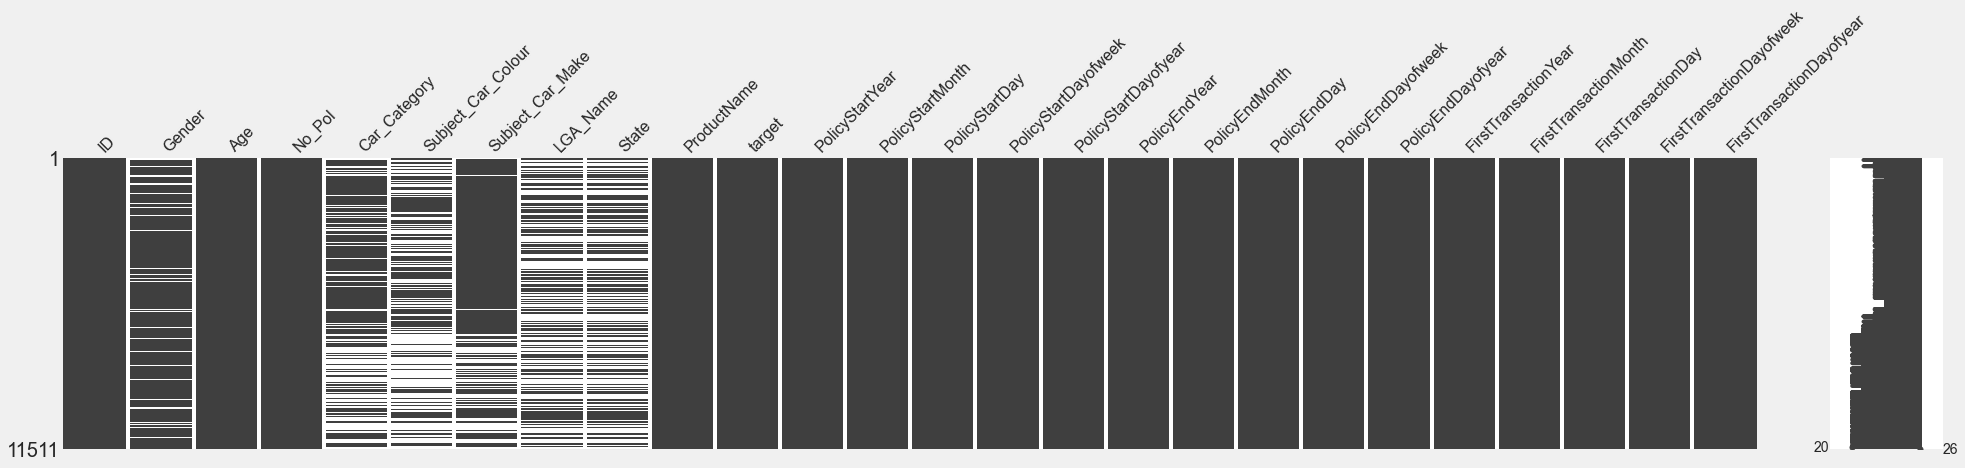

In [3766]:
# Visualizing the missing values in the dataset
missingno.matrix(train, figsize=(30, 5));

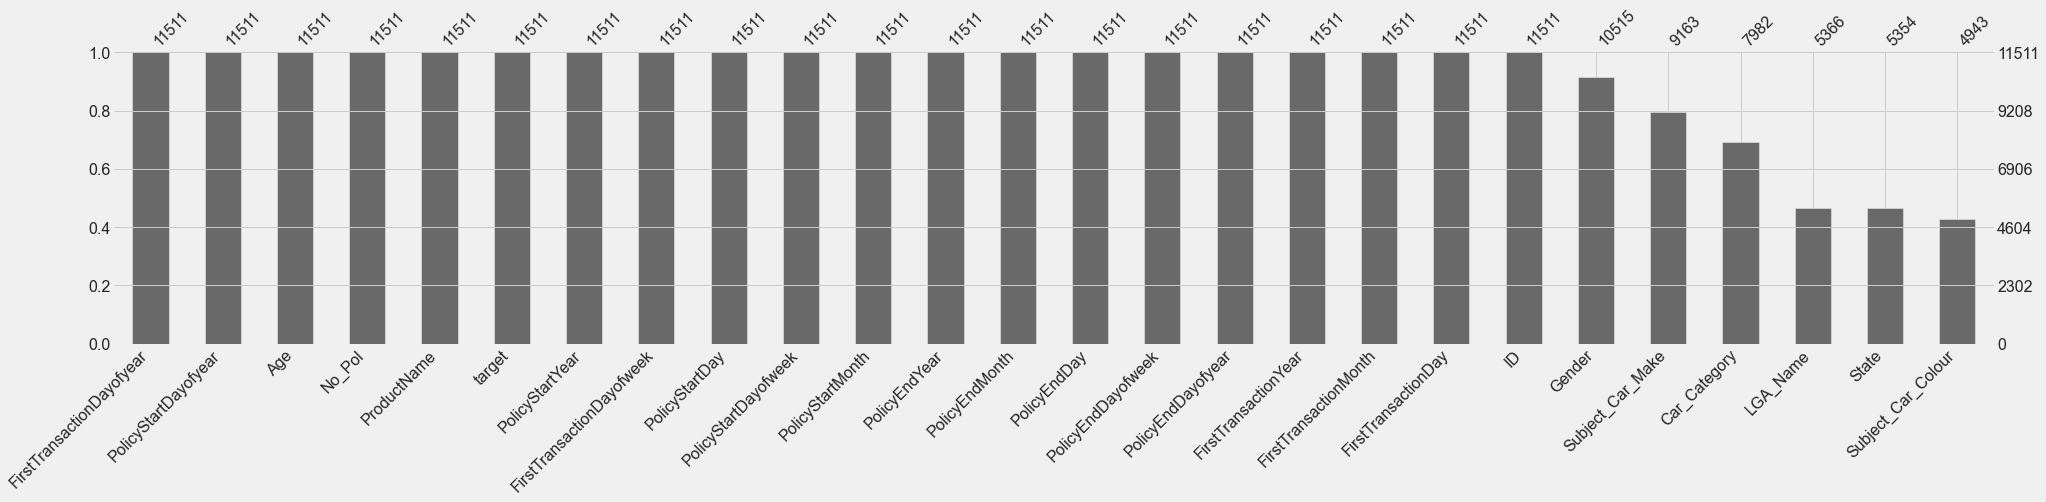

In [3767]:
# Visualize the missing values in the features in descending order
missingno.bar(train
              , sort='descending', figsize=(30, 5));

In [3768]:
# Check for missing categories and different datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11511 entries, 8010 to 7479
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         11511 non-null  object
 1   Gender                     10515 non-null  object
 2   Age                        11511 non-null  int64 
 3   No_Pol                     11511 non-null  int64 
 4   Car_Category               7982 non-null   object
 5   Subject_Car_Colour         4943 non-null   object
 6   Subject_Car_Make           9163 non-null   object
 7   LGA_Name                   5366 non-null   object
 8   State                      5354 non-null   object
 9   ProductName                11511 non-null  object
 10  target                     11511 non-null  int64 
 11  PolicyStartYear            11511 non-null  int64 
 12  PolicyStartMonth           11511 non-null  int64 
 13  PolicyStartDay             11511 non-null  int64 
 14  Poli

### Convert the strings into categories

In [3769]:
# Find the columns which contains strings
for label, content in train.drop(['ID', 'ProductName'], axis=1).items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State


In [3770]:
# This will turn all strings values into categories
for label, content in train.items():
    if pd.api.types.is_string_dtype(content):
        train[label]=content.astype('category').cat.as_ordered()

In [3771]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11511 entries, 8010 to 7479
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   ID                         11511 non-null  category
 1   Gender                     10515 non-null  category
 2   Age                        11511 non-null  int64   
 3   No_Pol                     11511 non-null  int64   
 4   Car_Category               7982 non-null   category
 5   Subject_Car_Colour         4943 non-null   category
 6   Subject_Car_Make           9163 non-null   category
 7   LGA_Name                   5366 non-null   category
 8   State                      5354 non-null   category
 9   ProductName                11511 non-null  category
 10  target                     11511 non-null  int64   
 11  PolicyStartYear            11511 non-null  int64   
 12  PolicyStartMonth           11511 non-null  int64   
 13  PolicyStartDay             11

All of our data is categorical and thus we can now turn the categories into integers, however it's still missing values....

In [3772]:
# Check the proportion of missing values
train.isnull().sum()/len(train)

ID                           0.000000
Gender                       0.086526
Age                          0.000000
No_Pol                       0.000000
Car_Category                 0.306576
Subject_Car_Colour           0.570585
Subject_Car_Make             0.203979
LGA_Name                     0.533837
State                        0.534880
ProductName                  0.000000
target                       0.000000
PolicyStartYear              0.000000
PolicyStartMonth             0.000000
PolicyStartDay               0.000000
PolicyStartDayofweek         0.000000
PolicyStartDayofyear         0.000000
PolicyEndYear                0.000000
PolicyEndMonth               0.000000
PolicyEndDay                 0.000000
PolicyEndDayofweek           0.000000
PolicyEndDayofyear           0.000000
FirstTransactionYear         0.000000
FirstTransactionMonth        0.000000
FirstTransactionDay          0.000000
FirstTransactionDayofweek    0.000000
FirstTransactionDayofyear    0.000000
dtype: float

### Filling and turning categorical variables into numbers

In [3773]:
for label, content in train.items():
    if pd.api.types.is_categorical_dtype(content):
        print(label)      

ID
Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State
ProductName


In [3774]:
# Check for which categorical columns have null(missing) values
for label, content in train.items():
    if pd.api.types.is_categorical_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State


In [3775]:
# Turn categorical variables into numbers
for label, content in train.items():
    # Check columns which are not numeric
    if not pd.api.types.is_numeric_dtype(content):
         
            # Add binary column to indicate whether sample had missing value
         train[label + '_is_missing'] = pd.isnull(content)
         
            # Turn categories into numbers and add +1 because pandas encodes missing categories as -1
         train[label] = pd.Categorical(content).codes + 1

In [3776]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11511 entries, 8010 to 7479
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   ID                             11511 non-null  int16
 1   Gender                         11511 non-null  int8 
 2   Age                            11511 non-null  int64
 3   No_Pol                         11511 non-null  int64
 4   Car_Category                   11511 non-null  int8 
 5   Subject_Car_Colour             11511 non-null  int8 
 6   Subject_Car_Make               11511 non-null  int8 
 7   LGA_Name                       11511 non-null  int16
 8   State                          11511 non-null  int8 
 9   ProductName                    11511 non-null  int8 
 10  target                         11511 non-null  int64
 11  PolicyStartYear                11511 non-null  int64
 12  PolicyStartMonth               11511 non-null  int64
 13  PolicyStartDay

In [3777]:
train.isna().sum()

ID                               0
Gender                           0
Age                              0
No_Pol                           0
Car_Category                     0
Subject_Car_Colour               0
Subject_Car_Make                 0
LGA_Name                         0
State                            0
ProductName                      0
target                           0
PolicyStartYear                  0
PolicyStartMonth                 0
PolicyStartDay                   0
PolicyStartDayofweek             0
PolicyStartDayofyear             0
PolicyEndYear                    0
PolicyEndMonth                   0
PolicyEndDay                     0
PolicyEndDayofweek               0
PolicyEndDayofyear               0
FirstTransactionYear             0
FirstTransactionMonth            0
FirstTransactionDay              0
FirstTransactionDayofweek        0
FirstTransactionDayofyear        0
ID_is_missing                    0
Gender_is_missing                0
Car_Category_is_miss

In [3778]:
train.head().T

8010   10526  10234  12066  8124 
ID                              7623  10025   9745  11499   7732
Gender                             1      2      2      2      1
Age                               37     37     41     48     44
No_Pol                             1      1      2      2      1
Car_Category                       3      3      3      3      0
Subject_Car_Colour                 5      5      5      0      0
Subject_Car_Make                   2      9      9      8      8
LGA_Name                           0     74    115      0     22
State                              0      7     21      0     21
ProductName                        4      2      4      4      1
target                             0      0      0      0      0
PolicyStartYear                 2001   2002   2003   2003   2005
PolicyStartMonth                  12      3      4     12      8
PolicyStartDay                    11     25     13     21      5
PolicyStartDayofweek               1      0      6      6      4
PolicyStartDayofyear             345     84    103    355    217
PolicyEndYear                   2011   2011   2011   2034   2011
PolicyEndMonth                    12      3      4      5      9
PolicyEndDay                      10     24     12     20     29
PolicyEndDayofweek                 5      3      1      5      3
PolicyEndDayofyear               344     83    102    140    272
FirstTransactionYear            2001   2002   2003   2003   2005
FirstTransactionMonth             12      3      4     12      8
FirstTransactionDay               11     25     13     21      5
FirstTransactionDayofweek          1      0      6      6      4
FirstTransactionDayofyear        345     84    103    355    217
ID_is_missing                  False  False  False  False  False
Gender_is_missing              False  False  False  False  False
Car_Category_is_missing        False  False  False  False   True
Subject_Car_Colour_is_missing  False  False  False   True   True
Subject_Car_Make_is_missing    False  False  False  False  False
LGA_Name_is_missing             True  False  False   True  False
State_is_missing                True  False  False   True  False
ProductName_is_missing         False  False  False  False  False

Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!

In [3779]:
len(train)

11511

In [3780]:
print('Rows containing 0 =', len(train[train['target']==0]))
print('Rows containing 1 =', len(train[train['target']==1]))

Rows containing 0 = 10112
Rows containing 1 = 1399


In [3781]:
train['target'].value_counts()

0    10112
1     1399
Name: target, dtype: int64

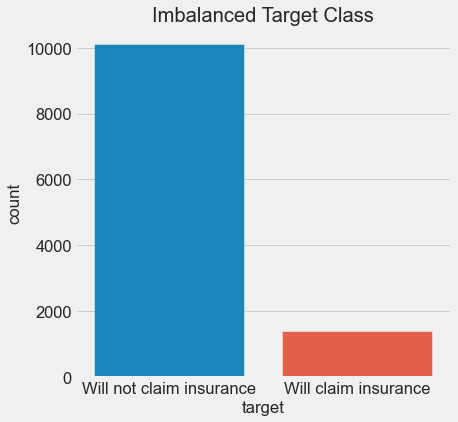

In [3782]:
# Visualize the target variable with a bar graph
plt.figure(figsize=(6, 6))
g = sns.countplot('target', data = train)
plt.title("Imbalanced Target Class")
g.set_xticklabels(['Will not claim insurance', 'Will claim insurance'])
plt.show();

In [3783]:
# Drop the _is_missing column
train.drop(['ID_is_missing', 'Gender_is_missing', 'Car_Category_is_missing', 'Subject_Car_Colour_is_missing',
        'Subject_Car_Make_is_missing', 'LGA_Name_is_missing', 'State_is_missing', 'ProductName_is_missing'], axis=1, inplace=True)
train.head()

ID  Gender  Age  No_Pol  Car_Category  Subject_Car_Colour  \
8010    7623       1   37       1             3                   5   
10526  10025       2   37       1             3                   5   
10234   9745       2   41       2             3                   5   
12066  11499       2   48       2             3                   0   
8124    7732       1   44       1             0                   0   

       Subject_Car_Make  LGA_Name  State  ProductName  ...  PolicyEndYear  \
8010                  2         0      0            4  ...           2011   
10526                 9        74      7            2  ...           2011   
10234                 9       115     21            4  ...           2011   
12066                 8         0      0            4  ...           2034   
8124                  8        22     21            1  ...           2011   

       PolicyEndMonth  PolicyEndDay  PolicyEndDayofweek  PolicyEndDayofyear  \
8010               12            10                   5                 344   
10526               3            24                   3                  83   
10234               4            12                   1                 102   
12066               5            20                   5                 140   
8124                9            29                   3                 272   

       FirstTransactionYear  FirstTransactionMonth  FirstTransactionDay  \
8010                   2001                     12                   11   
10526                  2002                      3                   25   
10234                  2003                      4                   13   
12066                  2003                     12                   21   
8124                   2005                      8                    5   

       FirstTransactionDayofweek  FirstTransactionDayofyear  
8010                           1                        345  
10526                          0                         84  
10234                          6                        103  
12066                          6                        355  
8124                           4                        217  

[5 rows x 26 columns]

### Splitting data into train/validation/test sets

In [3784]:
# Split the training dataset into X and y
X = train.drop('target', axis = 1)
y = train['target']

In [3785]:
X.shape, y.shape

((11511, 25), (11511,))

In [3786]:
y.value_counts()

0    10112
1     1399
Name: target, dtype: int64

## **5. Modelling**

<a id="models"></a>

### **What is Data Imbalance?**

Data imbalance usually reflects an unequal distribution of classes within a dataset. As with the data set we're working with, The proportion of customers who will claim a car insurance in the first 3 months and customers who will not claim a car insurance in the first 3 months is about 8.13 : 1. If we train our binary classification model without fixing this problem, the model will be completely biased towards the customers who will not claim a car insurance in the first 3 months. Since all of our data is numeric and there are no missing values and we have a highly imbalanced class, we'll attempt to balance the dataset by OverSampling and Undersampling the majority and minority class.

### Applying Oversampling technique for the training dataset(Random Oversampling Minority class)

With my training data created, I’ll upsample the minority class using the SMOTE algorithm (Synthetic Minority Oversampling Technique). At a high level, SMOTE creates synthetic observations of the minority class by:

* Finding the k-nearest-neighbors for minority class observations (finding similar observations)
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observation.

After upsampling to a class ratio of 1.0, I should have a balanced dataset. There’s no need (and often it’s not smart) to balance the classes, but it magnifies the issue caused by incorrectly timed oversampling.

In [3787]:
# summarize class distribution
print("Before Oversampling: ", Counter(y))

# over = RandomOverSampler(sampling_strategy='minority')
sm = SMOTE(sampling_strategy='minority', random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

Counter(y_sm)
print(f"After Oversampling: {Counter(y_sm)}")

Before Oversampling:  Counter({0: 10112, 1: 1399})
After Oversampling: Counter({0: 10112, 1: 10112})


In [3788]:
X_sm.shape, y_sm.shape

((20224, 25), (20224,))

In [3789]:
# split the new oversampled data
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.2, random_state = 42)

In [3790]:
len(X_train), len(y_test)

(16179, 4045)

We're going to be using 6 models to evaluate the sampled dataset:

* Logistic Regression
* RandomForestClassifier
* KNeighborClassifier
* LGBMClassifier
* CatBoostClassifier
* XGBClassifier

All of the algorithms in the Scikit-Learn library use the same functions, for training a model, model.fit(X_train, y_train) and for scoring a model model.score(X_test, y_test). score() returns the ratio of correct predictions (1.0 = 100% correct).

Metrics:

* Precision is the total number of customers the model correctly identified as customers that will claim insurance out of all the people PREDICTED to claim insurance

* Recall is the total number of customers the model correctly identified as customers that will claim insurance out of all the people who ACTUALLY claimed insurance.

* Accuracy is the total number of correct predictions divided by the total number of predictions.

* It is not possible to achieve both a high precision and a high recall value- we must determine which is more important for us in our model.

* F1 gives us the harmonic mean of precision and recall (Aim for a high F1 value to indicate a good precision and a good recall value).

* ROC (Receiver Operating Characteristic) Curve is a plot betwen the True Positive Rate on the y-axis and the False Positive Rate on the x-axis. A plot with the graph closer to the left and top axes is indicative of a better model.

* AUC (Area Under Curve) values range from 0 to 1 with higher scores indicating a better model. The diagonal line on ROC curves usually represents a random model with an AUC of 0.5. (Would definitely want our model's AUC to be higher than 0.5, since that would signify it is better than random chance.

* PRC (Precision-Recall Curves) plot values of precision scores on the y-axis and recall on the x-axis. A plot with the graph closer to the top and right axes is indicative of a better model. As with ROC curves, we should aim for a high AUC.

### 5.1 Logistic Regression

<a id="logreg"></a>

In [3791]:
# Logistic Regression
np.random.seed(42)

# Instantiate the model
log = LogisticRegression()

# Fit the model on the train data
log.fit(X_train, y_train)

# Score the model on the test data
log.score(X_test, y_test)

0.6702101359703337

In [3792]:
# Make predictions on the model
log_pred = log.predict(X_test)
log_pred[:10]

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

In [3793]:
y_test[:10]

4981     0
5421     0
16026    1
8057     0
119      0
18553    1
9814     0
9787     1
2699     0
19323    1
Name: target, dtype: int64

In [3794]:
print(classification_report(y_test, log_pred));

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2005
           1       0.67      0.67      0.67      2040

    accuracy                           0.67      4045
   macro avg       0.67      0.67      0.67      4045
weighted avg       0.67      0.67      0.67      4045



In [3795]:
print('Precision Score: ', round(precision_score(y_test, log_pred), 2))
print('Recall Score: ', round(recall_score(y_test, log_pred), 2))
print('F1 Score: ', round(f1_score(y_test, log_pred), 2))
print('Accuracy Score: ', round(accuracy_score(y_test, log_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, log_pred), 2))

Precision Score:  0.67
Recall Score:  0.67
F1 Score:  0.67
Accuracy Score:  0.67
ROC AUC:  0.67


### 5.1.1 Confusion Matrix of LogisticRegression Model

<a id="logreg"></a>

[[1343  662]
 [ 672 1368]]


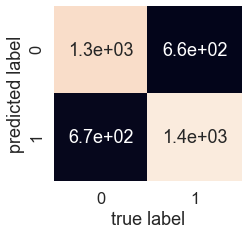

In [3796]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, log_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, log_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, log_pred)
print(confusion_matrix(y_test, log_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 662 occasaions where the model predicted 0 when it should've been 1 (false negative) and 672 occasions where the model predicted 1 instead of 0 (false positive).

### 5.1.2 ROC Curve and AUC Scores for the Logistic Regression model

<a id="logreg"></a>

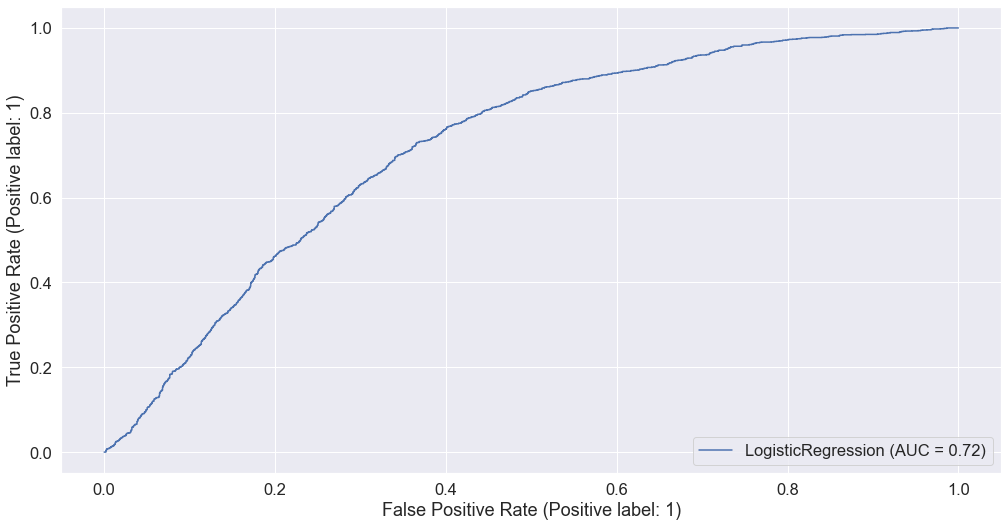

In [3797]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(log, X_test, y_test);

### 5.2 Random Forest

<a id="forest"></a>

In [3798]:
# Random Forest
np.random.seed(42)

# Instantiate the model
rf = RandomForestClassifier()

# # Fit the model on the training data
rf.fit(X_train, y_train)

# Score the model on the test data
rf.score(X_test, y_test)

0.892459826946848

In [3799]:
# Make predictions on the model
rf_pred = rf.predict(X_test)
rf_pred[:10]

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 1], dtype=int64)

In [3800]:
y_test[:10]

4981     0
5421     0
16026    1
8057     0
119      0
18553    1
9814     0
9787     1
2699     0
19323    1
Name: target, dtype: int64

In [3801]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2005
           1       0.89      0.90      0.89      2040

    accuracy                           0.89      4045
   macro avg       0.89      0.89      0.89      4045
weighted avg       0.89      0.89      0.89      4045



In [3802]:
print('Precision Score:', round(precision_score(y_test, rf_pred), 2))
print('Recall Score:', round(recall_score(y_test, rf_pred), 2))
print('F1 Score:', round(f1_score(y_test, rf_pred), 2))
print('Accuracy Score:', round(accuracy_score(y_test, rf_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, rf_pred), 2))

Precision Score: 0.89
Recall Score: 0.9
F1 Score: 0.89
Accuracy Score: 0.89
ROC AUC:  0.89


### 5.2.1 Confusion Matrix of RandomForest Model

<a id="forest"></a>

[[1766  239]
 [ 196 1844]]


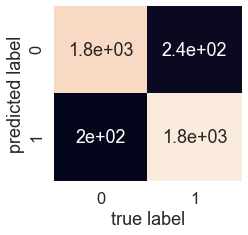

In [3803]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, rf_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, rf_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, rf_pred)
print(confusion_matrix(y_test, rf_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 239 occasaions where the model predicted 0 when it should've been 1 (false negative) and 196 occasions where the model predicted 1 instead of 0 (false positive).

### 5.2.2 ROC Curve and AUC Scores for the RandomForestClassifier Model

<a id="forest"></a>

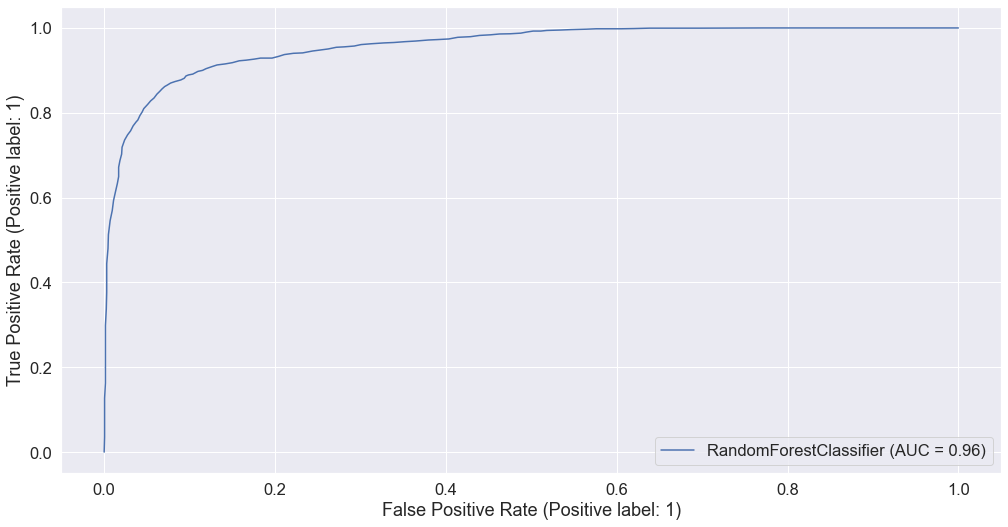

In [3804]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(rf, X_test, y_test);

This is great, the model does far better than guessing which would be a line going from the bottom left corner to the top right corner, AUC = 0.96. But a perfect model would achieve an AUC score of 1.0.

### 5.3 KNeighborsClassifier

<a id="neighbors"></a>

In [3805]:
np.random.seed(42)

# Instantiate the model
knn = KNeighborsClassifier()

# Fit the model to the training data
knn.fit(X_train, y_train)

# Score the model on the test data
knn.score(X_test, y_test)

0.8012360939431397

In [3806]:
# Make predictions on the model
knn_pred = knn.predict(X_test)
knn_pred[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 1], dtype=int64)

In [3807]:
y_test[:10]

4981     0
5421     0
16026    1
8057     0
119      0
18553    1
9814     0
9787     1
2699     0
19323    1
Name: target, dtype: int64

In [3808]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.92      0.66      0.77      2005
           1       0.74      0.94      0.83      2040

    accuracy                           0.80      4045
   macro avg       0.83      0.80      0.80      4045
weighted avg       0.83      0.80      0.80      4045



In [3809]:
print('Precision Score:', round(precision_score(y_test, knn_pred), 2))
print('Recall Score:', round(recall_score(y_test, knn_pred), 2))
print('F1 Score:', round(f1_score(y_test, knn_pred), 2))
print('Accuracy Score:', round(accuracy_score(y_test, knn_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, knn_pred), 2))

Precision Score: 0.74
Recall Score: 0.94
F1 Score: 0.83
Accuracy Score: 0.8
ROC AUC:  0.8


### 5.3.1 Confusion Matrix of KNeighborsClassifier Model

<a id="neighbors"></a>

[[1323  682]
 [ 122 1918]]


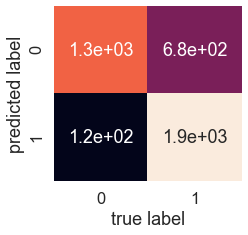

In [3810]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, knn_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, knn_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, knn_pred)
print(confusion_matrix(y_test, knn_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 682 occasaions where the model predicted 0 when it should've been 1 (false negative) and 122 occasions where the model predicted 1 instead of 0 (false positive).

### 5.3.2 ROC Curve and AUC Scores for the KNeighborsClassifier Model

<a id="neighbors"></a>

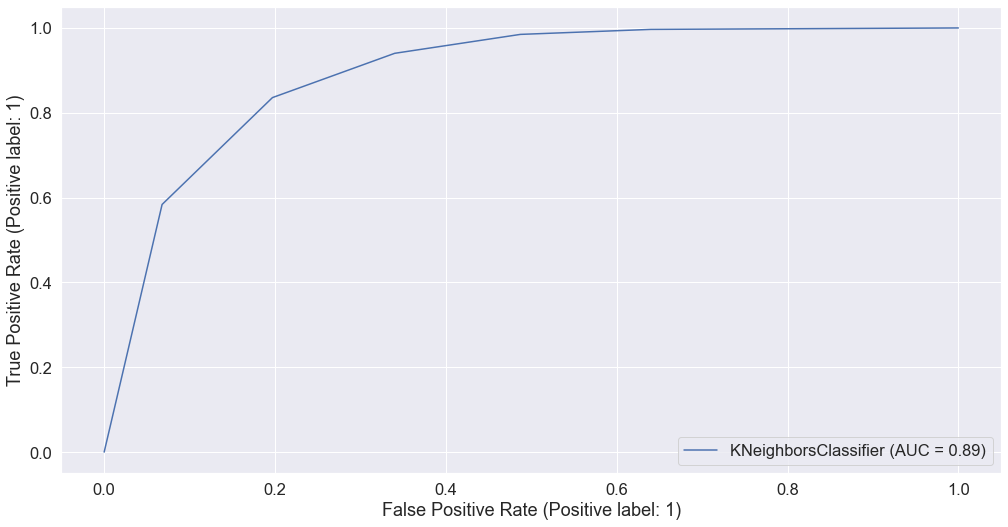

In [3811]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(knn, X_test, y_test);

This is great, the model does far better than guessing which would be a line going from the bottom left corner to the top right corner, AUC = 0.89. But a perfect model would achieve an AUC score of 1.0.

### 5.4 LightGBM Model

<a id="lgbm"></a>

In [3812]:
np.random.seed(42)

# Instantiate the model
lgbm = LGBMClassifier()

# Fit the model
lgbm.fit(X_train, y_train)

# Score the model on the test data
lgbm.score(X_test, y_test)

0.8956736711990111

In [3813]:
# Make predictions on the model
lgbm_pred = lgbm.predict(X_test)
lgbm_pred[:10]


array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1], dtype=int64)

In [3814]:
y_test[:10]

4981     0
5421     0
16026    1
8057     0
119      0
18553    1
9814     0
9787     1
2699     0
19323    1
Name: target, dtype: int64

In [3815]:
print(classification_report(y_test, lgbm_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      2005
           1       0.91      0.88      0.89      2040

    accuracy                           0.90      4045
   macro avg       0.90      0.90      0.90      4045
weighted avg       0.90      0.90      0.90      4045



In [3816]:
print('Precision Score:', round(precision_score(y_test, lgbm_pred), 2))
print('Recall Score:', round(recall_score(y_test, lgbm_pred), 2))
print('F1 Score:', round(f1_score(y_test, lgbm_pred), 2))
print('Accuracy Score:', round(accuracy_score(y_test, lgbm_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, lgbm_pred), 2))

Precision Score: 0.91
Recall Score: 0.88
F1 Score: 0.89
Accuracy Score: 0.9
ROC AUC:  0.9


### 5.4.1 Confusion Matrix of LightGBMClassifier Model

<a id="neighbors"></a>

[[1833  172]
 [ 250 1790]]


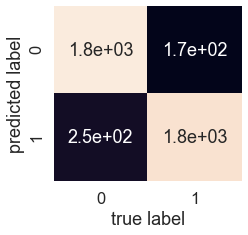

In [3817]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, lgbm_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, lgbm_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, lgbm_pred)
print(confusion_matrix(y_test, lgbm_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 172 occasaions where the model predicted 0 when it should've been 1 (false negative) and 250 occasions where the model predicted 1 instead of 0 (false positive).

### 5.4.2 ROC Curve and AUC Scores for the LightGBMClassifier Model

<a id="neighbors"></a>

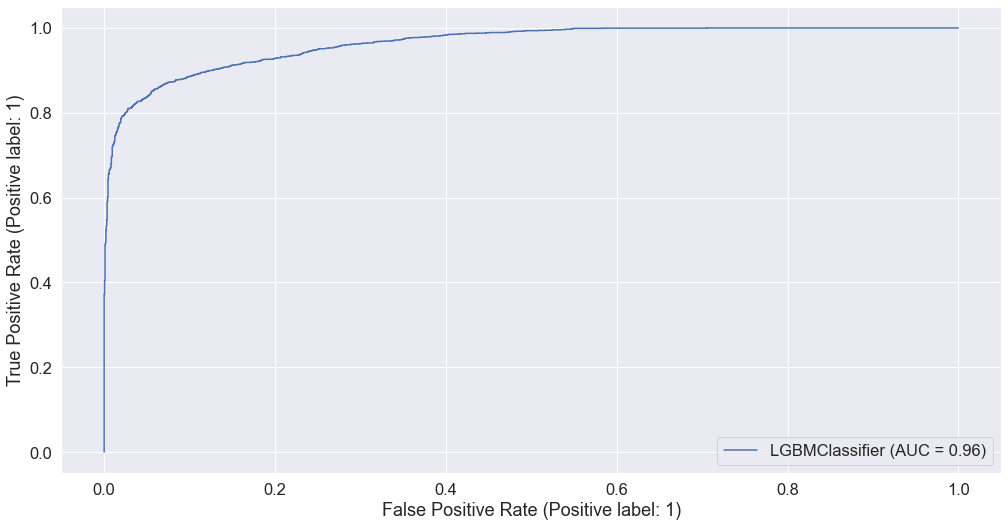

In [3818]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(lgbm, X_test, y_test);

This is great, the model does far better than guessing which would be a line going from the bottom left corner to the top right corner, AUC = 0.96. But a perfect model would achieve an AUC score of 1.0.

### 5.5 CatBoost Model

<a id="catboost"></a>

In [3819]:
np. random.seed(42)

# Instantiate the model
cat = CatBoostClassifier()

# Fit the model to the training data
cat.fit(X_train, y_train)

# Score the model on the test data
cat.score(X_test, y_test)

Learning rate set to 0.033819
0:	learn: 0.6712682	total: 53.6ms	remaining: 53.6s
1:	learn: 0.6572553	total: 74.7ms	remaining: 37.3s
2:	learn: 0.6424698	total: 95.7ms	remaining: 31.8s
3:	learn: 0.6251396	total: 116ms	remaining: 29s
4:	learn: 0.6116585	total: 135ms	remaining: 26.9s
5:	learn: 0.5981645	total: 155ms	remaining: 25.7s
6:	learn: 0.5883858	total: 174ms	remaining: 24.7s
7:	learn: 0.5801929	total: 200ms	remaining: 24.8s
8:	learn: 0.5699848	total: 224ms	remaining: 24.7s
9:	learn: 0.5610843	total: 254ms	remaining: 25.1s
10:	learn: 0.5542218	total: 286ms	remaining: 25.7s
11:	learn: 0.5493848	total: 310ms	remaining: 25.5s
12:	learn: 0.5421030	total: 334ms	remaining: 25.4s
13:	learn: 0.5352862	total: 357ms	remaining: 25.2s
14:	learn: 0.5306646	total: 381ms	remaining: 25s
15:	learn: 0.5264965	total: 406ms	remaining: 25s
16:	learn: 0.5198893	total: 429ms	remaining: 24.8s
17:	learn: 0.5144392	total: 452ms	remaining: 24.6s
18:	learn: 0.5085763	total: 474ms	remaining: 24.5s
19:	learn: 0.5

162:	learn: 0.3240534	total: 3.3s	remaining: 16.9s
163:	learn: 0.3234484	total: 3.32s	remaining: 16.9s
164:	learn: 0.3224481	total: 3.33s	remaining: 16.9s
165:	learn: 0.3220021	total: 3.35s	remaining: 16.9s
166:	learn: 0.3215427	total: 3.37s	remaining: 16.8s
167:	learn: 0.3210668	total: 3.39s	remaining: 16.8s
168:	learn: 0.3207147	total: 3.4s	remaining: 16.7s
169:	learn: 0.3201675	total: 3.42s	remaining: 16.7s
170:	learn: 0.3196579	total: 3.44s	remaining: 16.7s
171:	learn: 0.3190103	total: 3.45s	remaining: 16.6s
172:	learn: 0.3186680	total: 3.47s	remaining: 16.6s
173:	learn: 0.3182310	total: 3.48s	remaining: 16.5s
174:	learn: 0.3179345	total: 3.5s	remaining: 16.5s
175:	learn: 0.3175129	total: 3.52s	remaining: 16.5s
176:	learn: 0.3170810	total: 3.54s	remaining: 16.5s
177:	learn: 0.3167255	total: 3.56s	remaining: 16.4s
178:	learn: 0.3164670	total: 3.57s	remaining: 16.4s
179:	learn: 0.3159627	total: 3.59s	remaining: 16.3s
180:	learn: 0.3154177	total: 3.6s	remaining: 16.3s
181:	learn: 0.31

324:	learn: 0.2671640	total: 6.21s	remaining: 12.9s
325:	learn: 0.2667131	total: 6.23s	remaining: 12.9s
326:	learn: 0.2664364	total: 6.25s	remaining: 12.9s
327:	learn: 0.2661154	total: 6.26s	remaining: 12.8s
328:	learn: 0.2659024	total: 6.28s	remaining: 12.8s
329:	learn: 0.2656896	total: 6.29s	remaining: 12.8s
330:	learn: 0.2655026	total: 6.31s	remaining: 12.8s
331:	learn: 0.2652732	total: 6.32s	remaining: 12.7s
332:	learn: 0.2650162	total: 6.34s	remaining: 12.7s
333:	learn: 0.2646062	total: 6.36s	remaining: 12.7s
334:	learn: 0.2641961	total: 6.37s	remaining: 12.6s
335:	learn: 0.2639380	total: 6.38s	remaining: 12.6s
336:	learn: 0.2636339	total: 6.4s	remaining: 12.6s
337:	learn: 0.2634648	total: 6.42s	remaining: 12.6s
338:	learn: 0.2631299	total: 6.44s	remaining: 12.6s
339:	learn: 0.2626969	total: 6.46s	remaining: 12.5s
340:	learn: 0.2625376	total: 6.47s	remaining: 12.5s
341:	learn: 0.2624153	total: 6.49s	remaining: 12.5s
342:	learn: 0.2621792	total: 6.5s	remaining: 12.5s
343:	learn: 0.

483:	learn: 0.2339665	total: 9.08s	remaining: 9.68s
484:	learn: 0.2338320	total: 9.09s	remaining: 9.66s
485:	learn: 0.2336872	total: 9.11s	remaining: 9.64s
486:	learn: 0.2335232	total: 9.13s	remaining: 9.62s
487:	learn: 0.2333792	total: 9.15s	remaining: 9.6s
488:	learn: 0.2332022	total: 9.17s	remaining: 9.58s
489:	learn: 0.2331332	total: 9.19s	remaining: 9.56s
490:	learn: 0.2329681	total: 9.2s	remaining: 9.54s
491:	learn: 0.2328321	total: 9.22s	remaining: 9.52s
492:	learn: 0.2326682	total: 9.23s	remaining: 9.5s
493:	learn: 0.2324758	total: 9.25s	remaining: 9.47s
494:	learn: 0.2323193	total: 9.27s	remaining: 9.45s
495:	learn: 0.2321425	total: 9.29s	remaining: 9.44s
496:	learn: 0.2319933	total: 9.31s	remaining: 9.42s
497:	learn: 0.2318277	total: 9.33s	remaining: 9.4s
498:	learn: 0.2315322	total: 9.35s	remaining: 9.38s
499:	learn: 0.2313906	total: 9.36s	remaining: 9.36s
500:	learn: 0.2312012	total: 9.39s	remaining: 9.35s
501:	learn: 0.2311733	total: 9.4s	remaining: 9.33s
502:	learn: 0.231

651:	learn: 0.2071518	total: 12.3s	remaining: 6.56s
652:	learn: 0.2069922	total: 12.3s	remaining: 6.54s
653:	learn: 0.2068608	total: 12.3s	remaining: 6.53s
654:	learn: 0.2067450	total: 12.4s	remaining: 6.51s
655:	learn: 0.2066167	total: 12.4s	remaining: 6.49s
656:	learn: 0.2064567	total: 12.4s	remaining: 6.47s
657:	learn: 0.2063038	total: 12.4s	remaining: 6.45s
658:	learn: 0.2061555	total: 12.4s	remaining: 6.43s
659:	learn: 0.2059175	total: 12.4s	remaining: 6.41s
660:	learn: 0.2058012	total: 12.5s	remaining: 6.39s
661:	learn: 0.2056832	total: 12.5s	remaining: 6.37s
662:	learn: 0.2055634	total: 12.5s	remaining: 6.35s
663:	learn: 0.2054128	total: 12.5s	remaining: 6.33s
664:	learn: 0.2052362	total: 12.5s	remaining: 6.31s
665:	learn: 0.2051397	total: 12.5s	remaining: 6.29s
666:	learn: 0.2049839	total: 12.6s	remaining: 6.27s
667:	learn: 0.2048110	total: 12.6s	remaining: 6.25s
668:	learn: 0.2046835	total: 12.6s	remaining: 6.23s
669:	learn: 0.2045773	total: 12.6s	remaining: 6.21s
670:	learn: 

812:	learn: 0.1876925	total: 15.1s	remaining: 3.48s
813:	learn: 0.1875827	total: 15.1s	remaining: 3.46s
814:	learn: 0.1874015	total: 15.2s	remaining: 3.44s
815:	learn: 0.1872823	total: 15.2s	remaining: 3.42s
816:	learn: 0.1871389	total: 15.2s	remaining: 3.41s
817:	learn: 0.1870282	total: 15.2s	remaining: 3.39s
818:	learn: 0.1869611	total: 15.3s	remaining: 3.37s
819:	learn: 0.1868554	total: 15.3s	remaining: 3.35s
820:	learn: 0.1867649	total: 15.3s	remaining: 3.33s
821:	learn: 0.1866653	total: 15.3s	remaining: 3.31s
822:	learn: 0.1865257	total: 15.3s	remaining: 3.3s
823:	learn: 0.1864398	total: 15.3s	remaining: 3.28s
824:	learn: 0.1863280	total: 15.4s	remaining: 3.26s
825:	learn: 0.1861762	total: 15.4s	remaining: 3.24s
826:	learn: 0.1860560	total: 15.4s	remaining: 3.22s
827:	learn: 0.1859555	total: 15.4s	remaining: 3.2s
828:	learn: 0.1858086	total: 15.4s	remaining: 3.18s
829:	learn: 0.1857233	total: 15.5s	remaining: 3.17s
830:	learn: 0.1856096	total: 15.5s	remaining: 3.15s
831:	learn: 0.

977:	learn: 0.1712982	total: 18s	remaining: 405ms
978:	learn: 0.1712051	total: 18s	remaining: 386ms
979:	learn: 0.1710958	total: 18s	remaining: 368ms
980:	learn: 0.1709796	total: 18s	remaining: 349ms
981:	learn: 0.1709007	total: 18.1s	remaining: 331ms
982:	learn: 0.1708171	total: 18.1s	remaining: 312ms
983:	learn: 0.1707177	total: 18.1s	remaining: 294ms
984:	learn: 0.1706525	total: 18.1s	remaining: 276ms
985:	learn: 0.1705481	total: 18.1s	remaining: 257ms
986:	learn: 0.1704410	total: 18.1s	remaining: 239ms
987:	learn: 0.1703672	total: 18.2s	remaining: 221ms
988:	learn: 0.1703173	total: 18.2s	remaining: 202ms
989:	learn: 0.1702322	total: 18.2s	remaining: 184ms
990:	learn: 0.1701582	total: 18.2s	remaining: 165ms
991:	learn: 0.1700870	total: 18.2s	remaining: 147ms
992:	learn: 0.1699972	total: 18.3s	remaining: 129ms
993:	learn: 0.1699775	total: 18.3s	remaining: 110ms
994:	learn: 0.1699310	total: 18.3s	remaining: 91.9ms
995:	learn: 0.1698776	total: 18.3s	remaining: 73.5ms
996:	learn: 0.1698

0.9033374536464771

In [3820]:
# Make predictions on the model
cat_pred = cat.predict(X_test)
cat_pred[:10]

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1], dtype=int64)

In [3821]:
y_test[:10]

4981     0
5421     0
16026    1
8057     0
119      0
18553    1
9814     0
9787     1
2699     0
19323    1
Name: target, dtype: int64

In [3822]:
print(classification_report(y_test, cat_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2005
           1       0.92      0.88      0.90      2040

    accuracy                           0.90      4045
   macro avg       0.90      0.90      0.90      4045
weighted avg       0.90      0.90      0.90      4045



In [3823]:
print('Precision Score:', round(precision_score(y_test, cat_pred), 2))
print('Recall Score:', round(recall_score(y_test, cat_pred), 2))
print('F1 Score:', round(f1_score(y_test, cat_pred), 2))
print('Accuracy Score:', round(accuracy_score(y_test, cat_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, cat_pred), 2))

Precision Score: 0.92
Recall Score: 0.88
F1 Score: 0.9
Accuracy Score: 0.9
ROC AUC:  0.9


### 5.5.1 Confusion Matrix of CatBoostClassifier Model

<a id="neighbors"></a>

[[1851  154]
 [ 237 1803]]


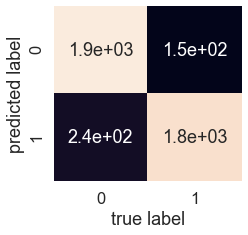

In [3824]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, cat_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, cat_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, cat_pred)
print(confusion_matrix(y_test, cat_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 154 occasaions where the model predicted 0 when it should've been 1 (false negative) and 237 occasions where the model predicted 1 instead of 0 (false positive).

### 5.5.2 ROC Curve and AUC Scores for the CatBoostClassifier Model

<a id="neighbors"></a>

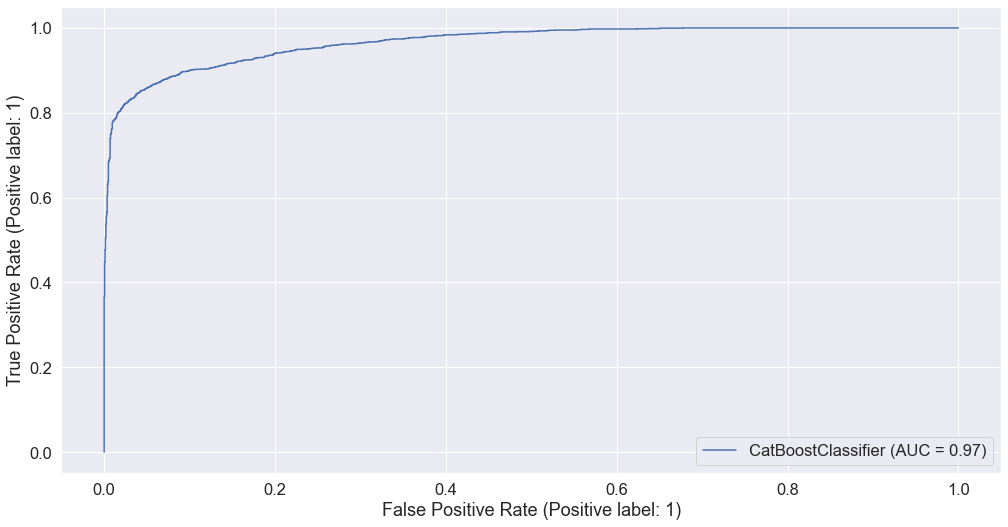

In [3825]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(cat, X_test, y_test);

This is great, the model does far better than guessing which would be a line going from the bottom left corner to the top right corner, AUC = 0.97. But a perfect model would achieve an AUC score of 1.0.

### 5.6 XGBoost

<a id="xgb"></a>

In [3826]:
np. random.seed(42)

# Instantiate the model
xg = XGBClassifier()

# Fit the model to the training data
xg.fit(X_train, y_train)

# Score the model on the test data
xg.score(X_test, y_test)

[09:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.907292954264524

In [3827]:
# Make predictions on the model
xg_pred = xg.predict(X_test)
xg_pred[:10]

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 1], dtype=int64)

In [3828]:
y_test[:10]

4981     0
5421     0
16026    1
8057     0
119      0
18553    1
9814     0
9787     1
2699     0
19323    1
Name: target, dtype: int64

In [3829]:
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2005
           1       0.92      0.89      0.91      2040

    accuracy                           0.91      4045
   macro avg       0.91      0.91      0.91      4045
weighted avg       0.91      0.91      0.91      4045



In [3830]:
print('Precision Score:', round(precision_score(y_test, xg_pred), 2))
print('Recall Score:', round(recall_score(y_test, xg_pred), 2))
print('F1 Score:', round(f1_score(y_test, xg_pred), 2))
print('Accuracy Score:', round(accuracy_score(y_test, xg_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, xg_pred), 2))

Precision Score: 0.92
Recall Score: 0.89
F1 Score: 0.91
Accuracy Score: 0.91
ROC AUC:  0.91


### 5.6.1 Confusion Matrix of XGBClassifier Model

<a id="neighbors"></a>

[[1847  158]
 [ 217 1823]]


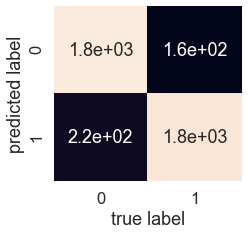

In [3831]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, xg_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, xg_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, xg_pred)
print(confusion_matrix(y_test, xg_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 158 occasaions where the model predicted 0 when it should've been 1 (false negative) and 217 occasions where the model predicted 1 instead of 0 (false positive).

### 5.6.2 ROC Curve and AUC Scores for the XGBClassifier Model

<a id="neighbors"></a>

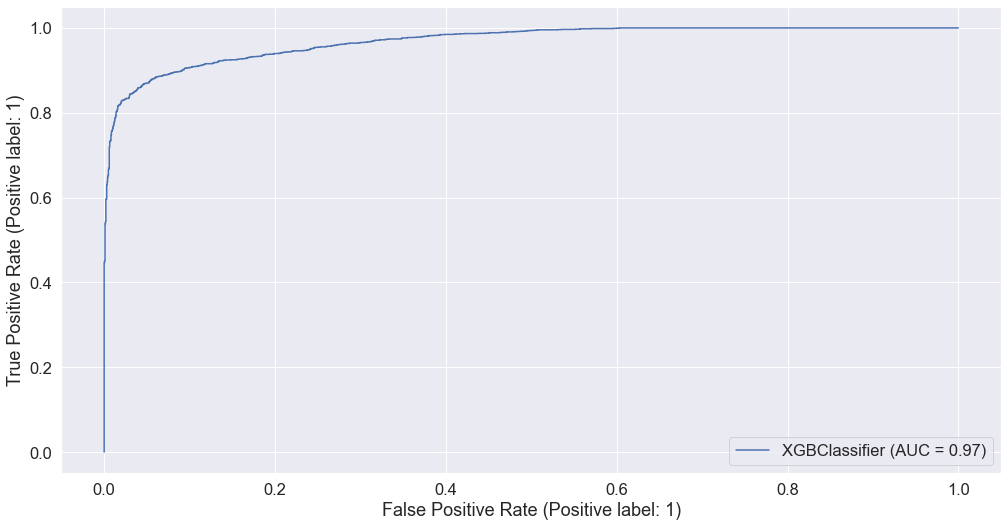

In [3832]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(xg, X_test, y_test);

This is great, the model does far better than guessing which would be a line going from the bottom left corner to the top right corner, AUC = 0.97. But a perfect model would achieve an AUC score of 1.0.

### Feature Importance

[09:53:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


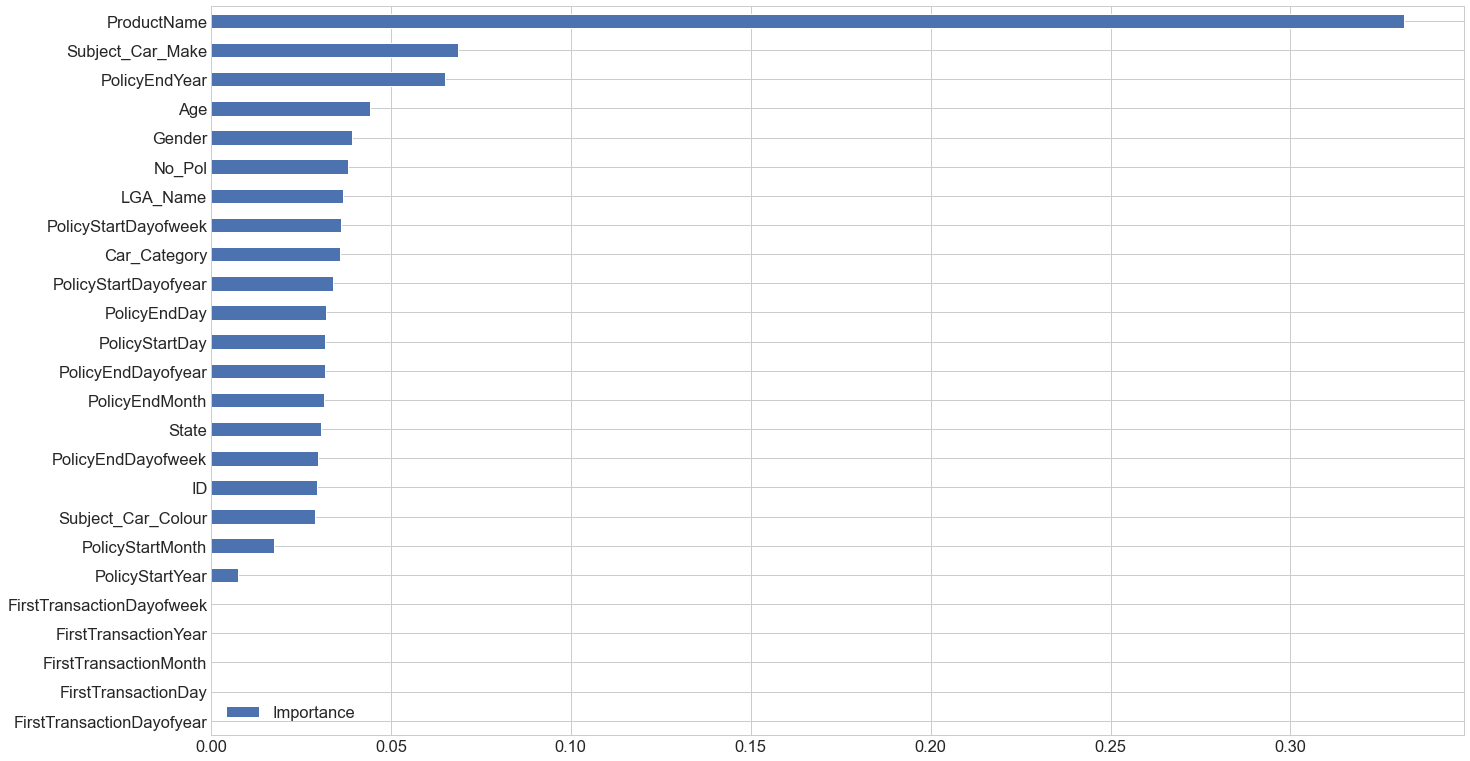

In [3834]:
# Using XGBoost to gain an insight on Feature Importance
clf = XGBClassifier()
clf.fit(train.drop('target', axis=1), train['target'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=train.drop('target', axis=1).columns, columns=['Importance'])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20, len(importance)/2));

### Correlation between independent variables

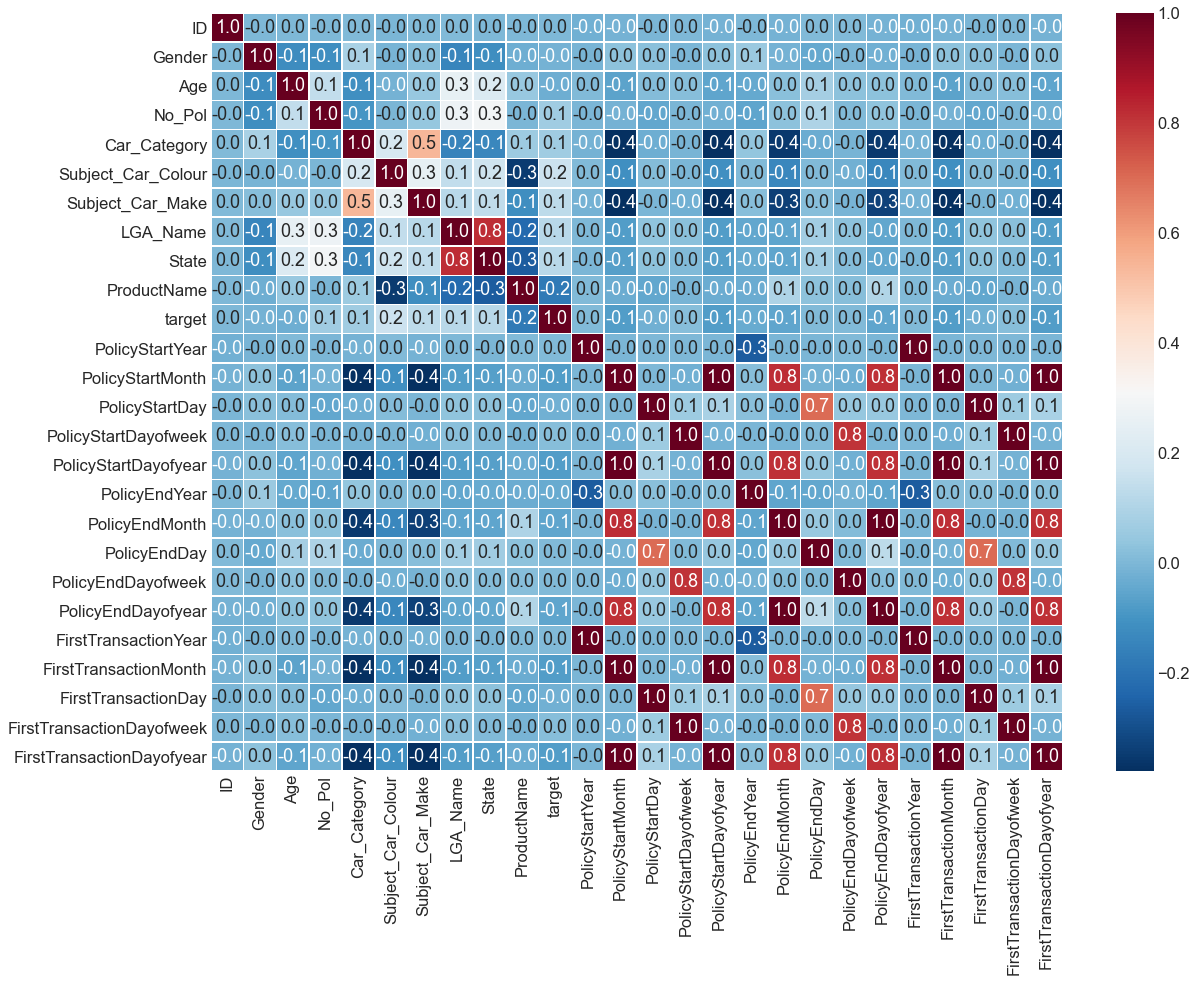

In [3835]:
# Find the correlation between the independent variables
corr_matrix = train.corr()
plt.figure(figsize=(17, 13))
sns.heatmap(corr_matrix,
            annot=True,
            linewidths=0.5,
            fmt='.1f',
            cmap="RdBu_r");

### Make predictions on test data

Now we've got a trained model, it's time to make predictions on the test data.

So what we're doing is trying to use the patterns our model has learned in the training data to predict whether a customer will claim insurance or not with characteristics it's never seen before but are assumed to be similar to that of those in the training data.

In [3836]:
test = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/Test.csv',
                   low_memory=False,
                    parse_dates=['Policy Start Date', 'Policy End Date', 'First Transaction Date'])
test.head()

ID Policy Start Date Policy End Date  Gender  Age  \
0  ID_01QM0NU        2010-10-23      2011-10-22  Female   46   
1  ID_024NJLZ        2010-10-14      2011-10-13    Male   32   
2  ID_02NOVWQ        2010-08-29      2011-08-28  Female   45   
3  ID_02VSP68        2010-06-13      2011-06-12  Female   58   
4  ID_02YB37K        2010-07-01      2011-06-30     NaN  120   

  First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0             2010-10-23       1          NaN                NaN   
1             2010-10-14       1          NaN                NaN   
2             2010-08-29       2       Saloon              Black   
3             2010-06-13       1       Saloon                NaN   
4             2010-07-01       1       Saloon                Red   

  Subject_Car_Make         LGA_Name            State  ProductName  
0             Ford  Abuja Municipal  Abuja-Municipal  Car Classic  
1              NaN           Kosofe            Benue  Car Classic  
2            Honda          Wuse 11            Abuja  Car Classic  
3           TOYOTA              NaN              NaN      CarSafe  
4          Hyundai  Victoria Island            Lagos  Car Classic

### Preprocessing the data(getting the test data in the same format as our training data)
​
Our model has been trained on data formatted in the same way as the training data.
​
This means in order to make predictions on the test data, we need to take the same steps we used to preprocess the training data to preprocess the test data.
​
Remember: Whatever you do to the training data, you have to do to the test data.
​
Let's create a function for doing so (by copying the preprocessing steps we used above).

In [3837]:
def preprocess_data(test):
    """
    performs transformations on test df and returns transformed test df
    """
    # Add datetime for Policy Start Date
    test['PolicyStartYear'] = test['Policy Start Date'].dt.year
    test['PolicyStartMonth'] = test['Policy Start Date'].dt.month
    test['PolicyStartDay'] = test['Policy Start Date'].dt.day
    test['PolicyStartDayofweek'] = test['Policy Start Date'].dt.dayofweek
    test['PolicyStartDayofyear'] = test['Policy Start Date'].dt.dayofyear

    # Drop original PolicyStartDate
    test.drop("Policy Start Date", axis=1, inplace=True)
    
    # Add datetime for Policy End Date
    test['PolicyEndYear'] = test['Policy End Date'].dt.year
    test['PolicyEndMonth'] = test['Policy End Date'].dt.month
    test['PolicyEndDay'] = test['Policy End Date'].dt.day
    test['PolicyEndDayofweek'] = test['Policy End Date'].dt.dayofweek
    test['PolicyEndDayofyear'] = test['Policy End Date'].dt.dayofyear

    # Drop original PolicyEndDate
    test.drop("Policy End Date", axis=1, inplace=True)
    
    # Add datetime for FirstTransactionDate
    test['FirstTransactionYear'] = test['First Transaction Date'].dt.year
    test['FirstTransactionMonth'] = test['First Transaction Date'].dt.month
    test['FirstTransactionDay'] = test['First Transaction Date'].dt.day
    test['FirstTransactionDayofweek'] = test['First Transaction Date'].dt.dayofweek
    test['FirstTransactionDayofyear'] = test['First Transaction Date'].dt.dayofyear

    # Drop original FirstTransactionDate
    test.drop("First Transaction Date", axis=1, inplace=True)
    
    test.reset_index(drop=True)
    
    # Find the columns which contains strings
    for label, content in test.drop(['ID', 'ProductName'], axis=1).items():
        if pd.api.types.is_string_dtype(content):
            print(label)
            
    # This will turn all strings values into categories
    for label, content in test.drop(['ID'], axis=1).items():
        if pd.api.types.is_string_dtype(content):
            test[label]=content.astype('category').cat.as_ordered()
            
    for label, content in test.items():
        if pd.api.types.is_categorical_dtype(content):
            print(label)
            
    # Check for which categorical columns have null(missing) values
    for label, content in test.items():
        if pd.api.types.is_categorical_dtype(content):
            if pd.isnull(content).sum():
                print(label)
                
    # Turn categorical variables into numbers
    for label, content in test.drop(['ID'], axis=1).items():
    
        # Check columns which are not numeric
        if not pd.api.types.is_numeric_dtype(content):
         
            # Add binary column to indicate whether sample had missing value
             test[label + '_is_missing'] = pd.isnull(content)
         
            # Turn categories into numbers and add +1 because pandas encodes missing categories as -1
             test[label] = pd.Categorical(content).codes + 1
                
    return(test)

In [3838]:
# Process the test data
test = preprocess_data(test)
test.head()

Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State
Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State
ProductName
Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State


ID  Gender  Age  No_Pol  Car_Category  Subject_Car_Colour  \
0  ID_01QM0NU       2   46       1             0                   0   
1  ID_024NJLZ       4   32       1             0                   0   
2  ID_02NOVWQ       2   45       2             7                   4   
3  ID_02VSP68       2   58       1             7                   0   
4  ID_02YB37K       0  120       1             7                  13   

   Subject_Car_Make  LGA_Name  State  ProductName  ...  FirstTransactionDay  \
0                10        10      4            2  ...                   23   
1                 0        70      8            2  ...                   14   
2                12       113      3            2  ...                   29   
3                35         0      0            5  ...                   13   
4                13       110     30            2  ...                    1   

   FirstTransactionDayofweek  FirstTransactionDayofyear  Gender_is_missing  \
0                          5                        296              False   
1                          3                        287              False   
2                          6                        241              False   
3                          6                        164              False   
4                          3                        182               True   

   Car_Category_is_missing  Subject_Car_Colour_is_missing  \
0                     True                           True   
1                     True                           True   
2                    False                          False   
3                    False                           True   
4                    False                          False   

   Subject_Car_Make_is_missing  LGA_Name_is_missing  State_is_missing  \
0                        False                False             False   
1                         True                False             False   
2                        False                False             False   
3                        False                 True              True   
4                        False                False             False   

   ProductName_is_missing  
0                   False  
1                   False  
2                   False  
3                   False  
4                   False  

[5 rows x 32 columns]

In [3839]:
# Drop the _is_missing column
test.drop(['Gender_is_missing', 'Car_Category_is_missing', 'Subject_Car_Colour_is_missing',
        'Subject_Car_Make_is_missing', 'LGA_Name_is_missing', 'State_is_missing', 'ProductName_is_missing'], axis=1, inplace=True)
test.head()

ID  Gender  Age  No_Pol  Car_Category  Subject_Car_Colour  \
0  ID_01QM0NU       2   46       1             0                   0   
1  ID_024NJLZ       4   32       1             0                   0   
2  ID_02NOVWQ       2   45       2             7                   4   
3  ID_02VSP68       2   58       1             7                   0   
4  ID_02YB37K       0  120       1             7                  13   

   Subject_Car_Make  LGA_Name  State  ProductName  ...  PolicyEndYear  \
0                10        10      4            2  ...           2011   
1                 0        70      8            2  ...           2011   
2                12       113      3            2  ...           2011   
3                35         0      0            5  ...           2011   
4                13       110     30            2  ...           2011   

   PolicyEndMonth  PolicyEndDay  PolicyEndDayofweek  PolicyEndDayofyear  \
0              10            22                   5                 295   
1              10            13                   3                 286   
2               8            28                   6                 240   
3               6            12                   6                 163   
4               6            30                   3                 181   

   FirstTransactionYear  FirstTransactionMonth  FirstTransactionDay  \
0                  2010                     10                   23   
1                  2010                     10                   14   
2                  2010                      8                   29   
3                  2010                      6                   13   
4                  2010                      7                    1   

   FirstTransactionDayofweek  FirstTransactionDayofyear  
0                          5                        296  
1                          3                        287  
2                          6                        241  
3                          6                        164  
4                          3                        182  

[5 rows x 25 columns]

In [3840]:
test.columns

Index(['ID', 'Gender', 'Age', 'No_Pol', 'Car_Category', 'Subject_Car_Colour',
       'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName',
       'PolicyStartYear', 'PolicyStartMonth', 'PolicyStartDay',
       'PolicyStartDayofweek', 'PolicyStartDayofyear', 'PolicyEndYear',
       'PolicyEndMonth', 'PolicyEndDay', 'PolicyEndDayofweek',
       'PolicyEndDayofyear', 'FirstTransactionYear', 'FirstTransactionMonth',
       'FirstTransactionDay', 'FirstTransactionDayofweek',
       'FirstTransactionDayofyear'],
      dtype='object')

In [3841]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         1202 non-null   object
 1   Gender                     1202 non-null   int8  
 2   Age                        1202 non-null   int64 
 3   No_Pol                     1202 non-null   int64 
 4   Car_Category               1202 non-null   int8  
 5   Subject_Car_Colour         1202 non-null   int8  
 6   Subject_Car_Make           1202 non-null   int8  
 7   LGA_Name                   1202 non-null   int8  
 8   State                      1202 non-null   int8  
 9   ProductName                1202 non-null   int8  
 10  PolicyStartYear            1202 non-null   int64 
 11  PolicyStartMonth           1202 non-null   int64 
 12  PolicyStartDay             1202 non-null   int64 
 13  PolicyStartDayofweek       1202 non-null   int64 
 14  PolicySt

In [3842]:
# This will turn ID strings values into categories
for label, content in test.items():
    if pd.api.types.is_string_dtype(content):
        test['ID']=content.astype('category').cat.as_ordered()

In [3843]:
# Turn ID categorical variables into integer
for label, content in test.items():
    # Turn categories into numbers and add +1 because pandas encodes missing categories as -1
         test['ID'] = pd.Categorical(content).codes + 1

In [3844]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   ID                         1202 non-null   int16
 1   Gender                     1202 non-null   int8 
 2   Age                        1202 non-null   int64
 3   No_Pol                     1202 non-null   int64
 4   Car_Category               1202 non-null   int8 
 5   Subject_Car_Colour         1202 non-null   int8 
 6   Subject_Car_Make           1202 non-null   int8 
 7   LGA_Name                   1202 non-null   int8 
 8   State                      1202 non-null   int8 
 9   ProductName                1202 non-null   int8 
 10  PolicyStartYear            1202 non-null   int64
 11  PolicyStartMonth           1202 non-null   int64
 12  PolicyStartDay             1202 non-null   int64
 13  PolicyStartDayofweek       1202 non-null   int64
 14  PolicyStartDayofyear    

In [3845]:
# Make predictions on the test dataset using the best model
test_preds = xg.predict(test)
test_preds[:10]

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

In [3846]:
y_test[:10]

4981     0
5421     0
16026    1
8057     0
119      0
18553    1
9814     0
9787     1
2699     0
19323    1
Name: target, dtype: int64

<AxesSubplot:ylabel='count'>

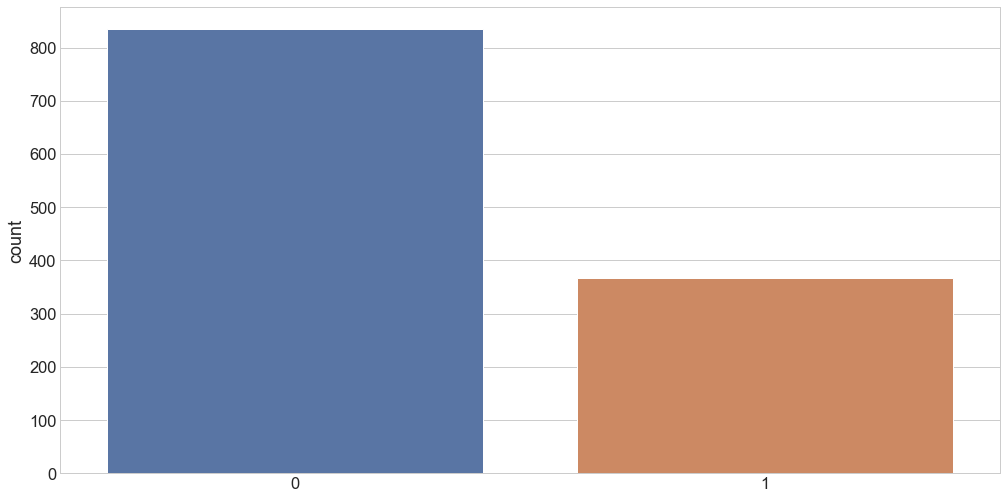

In [3847]:
sns.countplot(test_preds)

In [3848]:
set(test.ID==ss.ID)

{False}

In [3849]:
test.ID

0       258
1       249
2       211
3       142
4       158
       ... 
1197    294
1198     13
1199    181
1200     44
1201     69
Name: ID, Length: 1202, dtype: int16

In [3850]:
ss.head()

ID  target
0  ID_01QM0NU       0
1  ID_024NJLZ       0
2  ID_02NOVWQ       0
3  ID_02VSP68       0
4  ID_02YB37K       0

In [3851]:
sub_file = ss.copy()

In [3852]:
sub_file.target = test_preds

In [3853]:
sub_file.head()

ID  target
0  ID_01QM0NU       1
1  ID_024NJLZ       0
2  ID_02NOVWQ       1
3  ID_02VSP68       0
4  ID_02YB37K       0

In [3854]:
sub_file.to_csv('base_model_pred_model.csv', index=False)

##  **6. Conclusion**

<a id="conclusion"></a>

<p style="text-align:center;">Given its high scores across the board, XGBoost classifier performed slightly better than all the other machine learning models. With a high precision, recall and F1 score. This XGBoost model should be quite reliable at predicting which customers will claim insurance within the first 3 months.</p>

### Thanks for viewing this Notebook.